In [1]:
import os
import numpy as np
import pandas as pd
import plotly.express as px
from sklearn.preprocessing import StandardScaler

In [2]:
import pandas as pd

# Path ke file beras premium
file_path = "harga_beras_premium.csv"

# Baca dan olah data
df = pd.read_csv(file_path)
df = df.dropna()
df['Tanggal'] = pd.to_datetime(df['Tanggal'])
df['day'] = df['Tanggal'].dt.day
df['month'] = df['Tanggal'].dt.month
df['year'] = df['Tanggal'].dt.year
df['Komoditas'] = 'beras_premium'

# Lihat 6 baris pertama
df.head(6)


C:\Users\ASUS\AppData\Local\Temp\ipykernel_15872\2902599631.py:9: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Tanggal'] = pd.to_datetime(df['Tanggal'])


Tanggal      Komoditas             Provinsi    Harga  day  month  year
0 2022-05-19  beras_premium  Nusa Tenggara Barat  10600.0   19      5  2022
1 2022-05-19  beras_premium     Sulawesi Selatan  10895.0   19      5  2022
2 2022-05-19  beras_premium             Bengkulu  11475.0   19      5  2022
3 2022-05-19  beras_premium       D.I Yogyakarta  11200.0   19      5  2022
4 2022-05-19  beras_premium            Gorontalo  11250.0   19      5  2022
5 2022-05-19  beras_premium               Banten  11286.0   19      5  2022

In [102]:
df

Tanggal      Komoditas             Provinsi    Harga  day  month  \
0     2022-05-19  beras_premium  Nusa Tenggara Barat  10600.0   19      5   
1     2022-05-19  beras_premium     Sulawesi Selatan  10895.0   19      5   
2     2022-05-19  beras_premium             Bengkulu  11475.0   19      5   
3     2022-05-19  beras_premium       D.I Yogyakarta  11200.0   19      5   
4     2022-05-19  beras_premium            Gorontalo  11250.0   19      5   
...          ...            ...                  ...      ...  ...    ...   
13785 2023-05-16  beras_premium     Kalimantan Utara  15650.0   16      5   
13786 2023-05-16  beras_premium          Papua Barat  16063.0   16      5   
13787 2023-05-16  beras_premium                Papua  16125.0   16      5   
13788 2023-05-16  beras_premium       Sumatera Barat  15750.0   16      5   
13789 2023-05-16  beras_premium   Kalimantan Selatan  17519.0   16      5   

       year  
0      2022  
1      2022  
2      2022  
3      2022  
4      2022  
...     ...  
13785  2023  
13786  2023  
13787  2023  
13788  2023  
13789  2023  

[11169 rows x 7 columns]

In [3]:
# Urutkan berdasarkan tanggal
df_sorted = df.sort_values("Tanggal").reset_index(drop=True)

# Split 80% untuk train, 20% untuk test
split_idx = int(0.8 * len(df_sorted))
df_train = df_sorted.iloc[:split_idx].copy()
df_test = df_sorted.iloc[split_idx:].copy()

# Simpan ke file CSV
df_train.to_csv("train_beras.csv", index=False)
df_test.to_csv("test_beras.csv", index=False)


In [4]:
from sklearn.preprocessing import LabelEncoder

# Label Encoding untuk kolom Provinsi
encoder_provinsi = LabelEncoder()
df_train['provinsi_encoded'] = encoder_provinsi.fit_transform(df_train['Provinsi'])
df_test['provinsi_encoded'] = encoder_provinsi.transform(df_test['Provinsi'])

# Drop null jika ada
df_train = df_train.dropna()
df_test = df_test.dropna()

# Konfirmasi hasil
print("Training set:", df_train.shape)
print("Testing set:", df_test.shape)
print("Fitur numerik untuk model:", df_train.columns.tolist())


Training set: (8935, 8)
Testing set: (2234, 8)
Fitur numerik untuk model: ['Tanggal', 'Komoditas', 'Provinsi', 'Harga', 'day', 'month', 'year', 'provinsi_encoded']


In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
import numpy as np

# Fitur dan target
feature_cols = ['day', 'month', 'year', 'provinsi_encoded']
target_col = 'Harga'

# Scaling
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(df_train[feature_cols])
y_train_scaled = scaler_y.fit_transform(df_train[[target_col]])

X_test_scaled = scaler_X.transform(df_test[feature_cols])
y_test_scaled = scaler_y.transform(df_test[[target_col]])

# Reshape untuk LSTM: (samples, timesteps, features)
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Model LSTM
model = Sequential([
    LSTM(64, input_shape=(1, X_train_scaled.shape[1]), activation='tanh'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# Callback EarlyStopping
early_stop = EarlyStopping(patience=30, restore_best_weights=True)

# Training
history = model.fit(
    X_train_lstm, y_train_scaled,
    validation_data=(X_test_lstm, y_test_scaled),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/100


C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


280/280 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.9454 - val_loss: 0.7691
Epoch 2/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8262 - val_loss: 0.6753
Epoch 3/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7503 - val_loss: 0.7036
Epoch 4/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7389 - val_loss: 0.6665
Epoch 5/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7473 - val_loss: 0.6729
Epoch 6/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7371 - val_loss: 0.6651
Epoch 7/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7433 - val_loss: 0.6874
Epoch 8/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7265 - val_loss: 0.6653
Epoch 9/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7480 - val_loss: 0.6481
Epoch 10/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7206 - val_loss: 0.6500
Epoch 11/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7206 - val_loss: 0.6281
Epoch 12/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

### LSTM

In [6]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Fitur dan target
feature_cols = ['day', 'month', 'year', 'provinsi_encoded']
target_col = 'Harga'

# Standarisasi
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(df_train[feature_cols])
y_train_scaled = scaler_y.fit_transform(df_train[[target_col]])

X_test_scaled = scaler_X.transform(df_test[feature_cols])
y_test_scaled = scaler_y.transform(df_test[[target_col]])

# Reshape untuk LSTM: (samples, timesteps, features)
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Model LSTM
model = Sequential([
    LSTM(64, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]), activation='tanh'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# Callback early stopping
early_stop = EarlyStopping(patience=30, restore_best_weights=True)

# Training
history = model.fit(
    X_train_lstm, y_train_scaled,
    validation_data=(X_test_lstm, y_test_scaled),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/100


C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


280/280 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.9630 - val_loss: 0.7839
Epoch 2/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8344 - val_loss: 0.6969
Epoch 3/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7629 - val_loss: 0.6748
Epoch 4/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7641 - val_loss: 0.6644
Epoch 5/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7619 - val_loss: 0.6856
Epoch 6/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7495 - val_loss: 0.6576
Epoch 7/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7404 - val_loss: 0.6714
Epoch 8/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7407 - val_loss: 0.6689
Epoch 9/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7277 - val_loss: 0.6754
Epoch 10/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7391 - val_loss: 0.6435
Epoch 11/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7335 - val_loss: 0.6302
Epoch 12/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

In [7]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Prediksi pada data uji
y_pred_scaled = model.predict(X_test_lstm)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_test_scaled)

# Evaluasi performa model
mae = mean_absolute_error(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)

# Tampilkan hasil evaluasi
print("Evaluasi Prediksi Harga Beras Premium (Model LSTM):")
print(f"MAE   : {mae:.2f}")
print(f"MAPE  : {mape:.2f}%")
print(f"MSE   : {mse:.2f}")
print(f"RMSE  : {rmse:.2f}")
print(f"R²    : {r2:.4f}")


70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Evaluasi Prediksi Harga Beras Premium (Model LSTM):
MAE   : 740.07
MAPE  : 5.31%
MSE   : 918626.49
RMSE  : 958.45
R²    : 0.5012


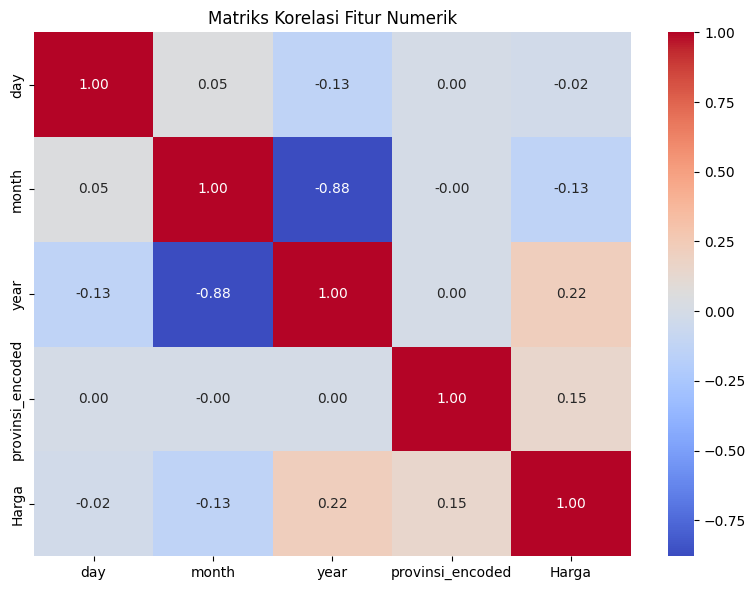

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ambil hanya kolom numerik dari df_train
numeric_cols = ['day', 'month', 'year', 'provinsi_encoded', 'Harga']

# Hitung korelasi
corr_matrix = df_train[numeric_cols].corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriks Korelasi Fitur Numerik")
plt.tight_layout()
plt.show()


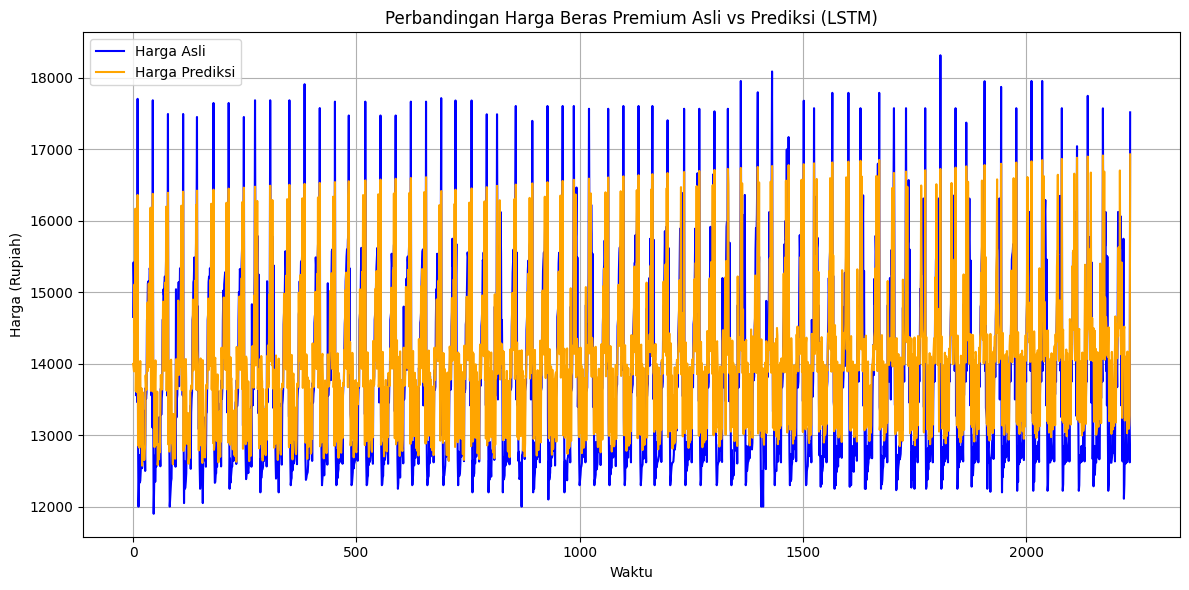

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(y_true, label='Harga Asli', color='blue')
plt.plot(y_pred, label='Harga Prediksi', color='orange')
plt.title('Perbandingan Harga Beras Premium Asli vs Prediksi (LSTM)')
plt.xlabel('Waktu')
plt.ylabel('Harga (Rupiah)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [10]:
y_true_flat = y_true.ravel()
y_pred_flat = y_pred.ravel()

# Buat DataFrame untuk membandingkan
df_prediksi = pd.DataFrame({
    'Harga Asli': y_true_flat,
    'Harga Prediksi': y_pred_flat
})

# Tampilkan 10 data teratas
print(df_prediksi.head(10))

   Harga Asli  Harga Prediksi
0     14656.0    13998.250000
1     15419.0    13950.511719
2     15125.0    13894.053711
3     15167.0    15110.212891
4     15310.0    14427.793945
5     15493.0    16170.497070
6     15833.0    13614.387695
7     13557.0    14158.470703
8     15070.0    14040.996094
9     13464.0    13601.667969


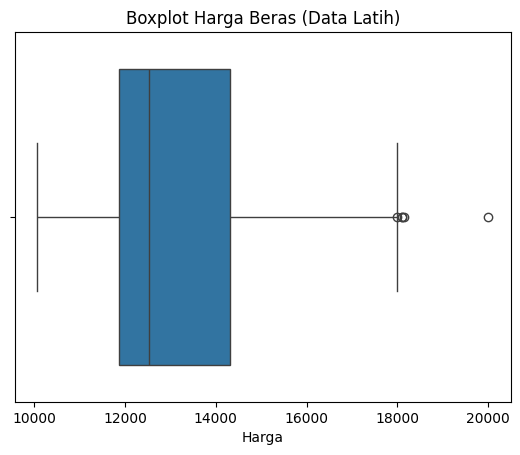

In [11]:
sns.boxplot(x=df_train['Harga'])
plt.title("Boxplot Harga Beras (Data Latih)")
plt.show()


In [12]:
q1 = df_train['Harga'].quantile(0.25)
q3 = df_train['Harga'].quantile(0.75)
iqr = q3 - q1
batas_atas = q3 + 1.5 * iqr
batas_bawah = q1 - 1.5 * iqr
df_train_filtered = df_train[(df_train['Harga'] >= batas_bawah) & (df_train['Harga'] <= batas_atas)]


In [13]:
def remove_outliers(df, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return df[(df[column] >= lower) & (df[column] <= upper)]

df_train_filtered = remove_outliers(df_train, 'Harga')

In [14]:
def add_time_features(df):
    df['sin_month'] = np.sin(2 * np.pi * df['month'] / 12)
    df['cos_month'] = np.cos(2 * np.pi * df['month'] / 12)
    df['Harga_MA3'] = df['Harga'].rolling(window=3, min_periods=1).mean()
    return df

df_train_filtered = add_time_features(df_train_filtered)
df_test = add_time_features(df_test)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_15872\2217509114.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sin_month'] = np.sin(2 * np.pi * df['month'] / 12)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_15872\2217509114.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cos_month'] = np.cos(2 * np.pi * df['month'] / 12)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_15872\2217509114.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

In [15]:
feature_cols = ['day', 'month', 'year', 'provinsi_encoded', 'sin_month', 'cos_month', 'Harga_MA3']
target_col = 'Harga'

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(df_train_filtered[feature_cols])
y_train_scaled = scaler_y.fit_transform(df_train_filtered[[target_col]])

X_test_scaled = scaler_X.transform(df_test[feature_cols])
y_test_scaled = scaler_y.transform(df_test[[target_col]])

# LSTM input: reshape to (samples, timesteps, features)
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

In [16]:
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(1, X_train_lstm.shape[2]), activation='tanh'),
    LSTM(32, activation='tanh'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mae')  # MAE lebih robust terhadap outlier

early_stop = EarlyStopping(patience=20, restore_best_weights=True)

history = model.fit(
    X_train_lstm, y_train_scaled,
    validation_data=(X_test_lstm, y_test_scaled),
    epochs=100,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100


C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


559/559 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4900 - val_loss: 0.2843
Epoch 2/100
559/559 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2724 - val_loss: 0.2772
Epoch 3/100
559/559 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2720 - val_loss: 0.2766
Epoch 4/100
559/559 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2738 - val_loss: 0.2761
Epoch 5/100
559/559 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2668 - val_loss: 0.2677
Epoch 6/100
559/559 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2678 - val_loss: 0.2664
Epoch 7/100
559/559 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2619 - val_loss: 0.2718
Epoch 8/100
559/559 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2637 - val_loss: 0.2683
Epoch 9/100
559/559 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2630 - val_loss: 0.2648
Epoch 10/100
559/559 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2590 - val_loss: 0.2736
Epoch 11/100
559/559 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2530 - val_loss: 0.2714
Epoch 12/100
559/559 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

In [17]:
y_pred_scaled = model.predict(X_test_lstm)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_test_scaled)

70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [18]:
mae = mean_absolute_error(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)

print("\n📊 Evaluasi Model LSTM Dua Lapis:")
print(f"MAE   : {mae:.2f}")
print(f"MAPE  : {mape:.2f}%")
print(f"MSE   : {mse:.2f}")
print(f"RMSE  : {rmse:.2f}")
print(f"R²    : {r2:.4f}")


📊 Evaluasi Model LSTM Dua Lapis:
MAE   : 319.01
MAPE  : 2.28%
MSE   : 265014.15
RMSE  : 514.80
R²    : 0.8561


In [19]:
tanggal = pd.to_datetime(df_test['Tanggal'].reset_index(drop=True)).iloc[:len(y_true)]

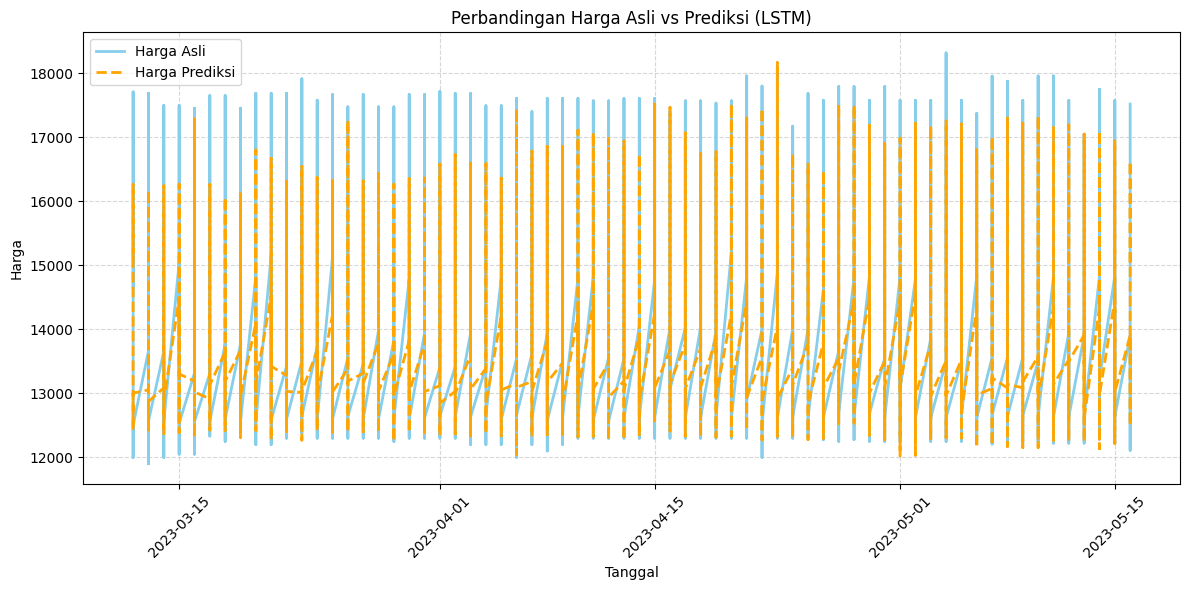

In [20]:
plt.figure(figsize=(12, 6))
plt.plot(tanggal, y_true, label='Harga Asli', color='skyblue', linewidth=2)
plt.plot(tanggal, y_pred, label='Harga Prediksi', color='orange', linestyle='--', linewidth=2)

plt.xlabel('Tanggal')
plt.ylabel('Harga')
plt.title('Perbandingan Harga Asli vs Prediksi (LSTM)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [21]:
# Ambil tanggal sesuai panjang y_pred (10 data pertama)
tanggal = pd.to_datetime(df_test['Tanggal'].reset_index(drop=True)).iloc[:10]

# Buat DataFrame perbandingan
df_result = pd.DataFrame({
    'Tanggal': list(tanggal),
    'Harga Asli': list(np.array(y_true[:10]).flatten()),
    'Harga Prediksi': list(np.array(y_pred[:10]).flatten())
})


print(df_result)


     Tanggal  Harga Asli  Harga Prediksi
0 2023-03-12     14656.0    15104.365234
1 2023-03-12     15419.0    15351.933594
2 2023-03-12     15125.0    15334.092773
3 2023-03-12     15167.0    15183.720703
4 2023-03-12     15310.0    14898.362305
5 2023-03-12     15493.0    15689.546875
6 2023-03-12     15833.0    15480.863281
7 2023-03-12     13557.0    14727.279297
8 2023-03-12     15070.0    14949.378906
9 2023-03-12     13464.0    13590.469727


In [24]:
print(df_test['Tanggal'].value_counts().head(5))


Tanggal
2023-03-13    34
2023-03-14    34
2023-04-15    34
2023-03-15    34
2023-03-16    34
Name: count, dtype: int64


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


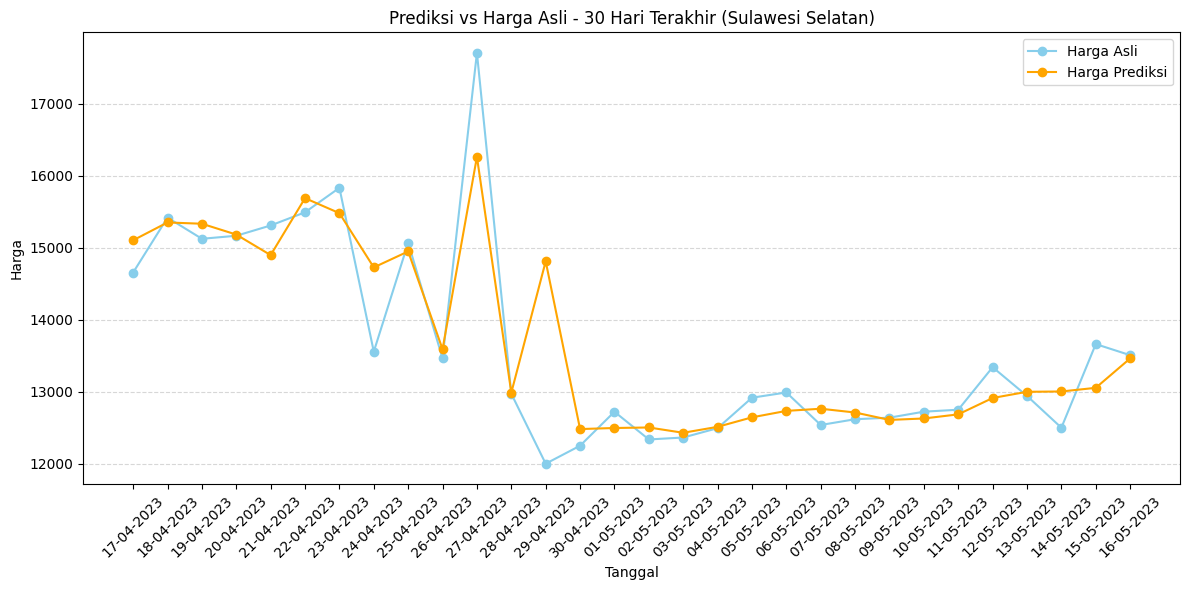

In [26]:
# Step 1-4: Ambil 30 hari terakhir provinsi Sulawesi Selatan
df_test_ss = df_test[df_test['Provinsi'] == 'Sulawesi Selatan'].copy()
df_test_ss['Tanggal'] = pd.to_datetime(df_test_ss['Tanggal'])
df_test_ss = df_test_ss.sort_values('Tanggal').drop_duplicates('Tanggal', keep='first')
df_test_ss_last30 = df_test_ss.tail(30).reset_index(drop=True)

# Step 5: Ambil index di X_test_lstm & y_test_scaled sesuai baris df_test_ss_last30
idx_last30 = df_test_ss_last30.index
X_last30 = X_test_lstm[idx_last30]
y_true_last30 = scaler_y.inverse_transform(y_test_scaled[idx_last30])
y_pred_last30 = scaler_y.inverse_transform(model.predict(X_last30))

# Step 6: Buat plot
plt.figure(figsize=(12, 6))
x = np.arange(30)

plt.plot(x, y_true_last30.flatten(), marker='o', label='Harga Asli', color='skyblue')
plt.plot(x, y_pred_last30.flatten(), marker='o', label='Harga Prediksi', color='orange')

tanggal_labels = df_test_ss_last30['Tanggal'].dt.strftime('%d-%m-%Y')
plt.xticks(x, labels=tanggal_labels, rotation=45)

plt.xlabel('Tanggal')
plt.ylabel('Harga')
plt.title('Prediksi vs Harga Asli - 30 Hari Terakhir (Sulawesi Selatan)')
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


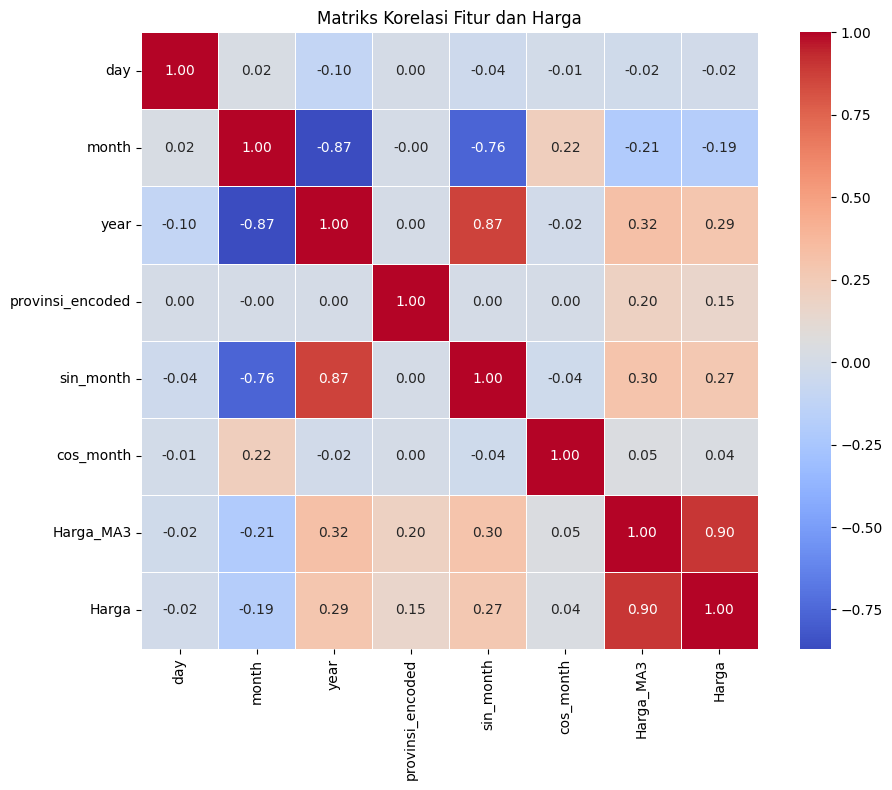

In [126]:
df_all = pd.concat([df_train_filtered, df_test], ignore_index=True)

# Pastikan fitur tambahan sudah ada
df_all = add_time_features(df_all)

# Ambil fitur dan target
cols = ['day', 'month', 'year', 'provinsi_encoded', 'sin_month', 'cos_month', 'Harga_MA3', 'Harga']
corr_matrix = df_all[cols].corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True, linewidths=0.5)
plt.title('Matriks Korelasi Fitur dan Harga')
plt.tight_layout()
plt.show()


### Prophet

In [ ]:
from prophet import Prophet

# Buat salinan data
df_prophet = df_train[['Tanggal', 'Harga']].copy()
df_prophet.rename(columns={'Tanggal': 'ds', 'Harga': 'y'}, inplace=True)

# Model Prophet
model = Prophet()
model.fit(df_prophet)


C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
05:14:46 - cmdstanpy - INFO - Chain [1] start processing
05:14:47 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:
# Buat future dataframe
future = model.make_future_dataframe(periods=30)

# Prediksi
forecast = model.predict(future)


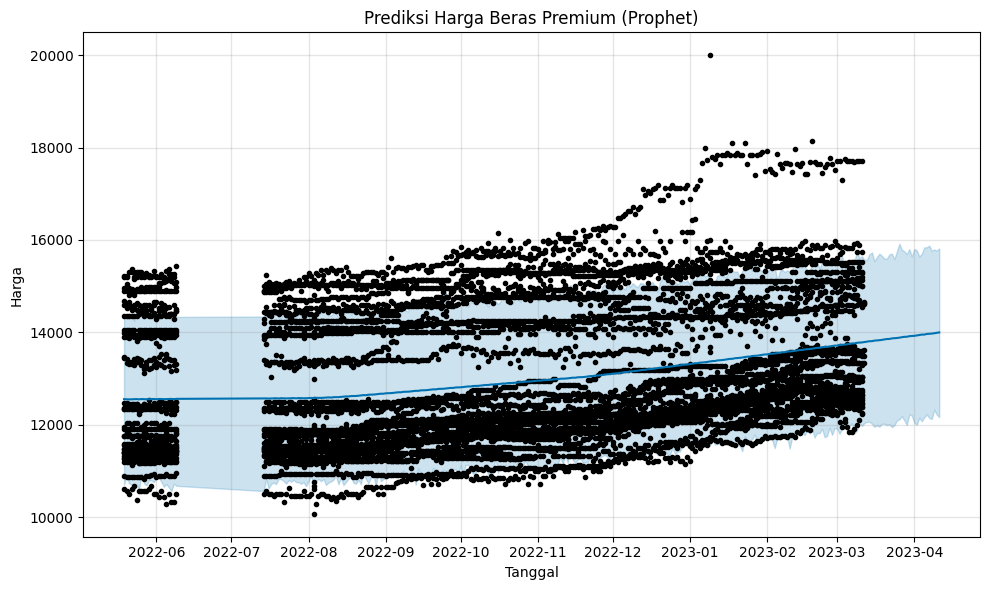

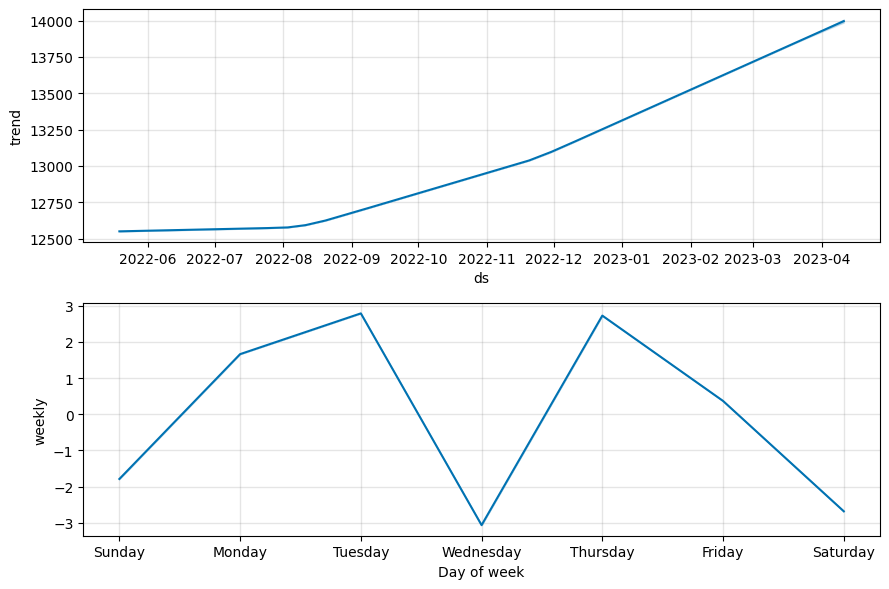

In [ ]:
# Plot hasil prediksi
model.plot(forecast)
plt.title("Prediksi Harga Beras Premium (Prophet)")
plt.xlabel("Tanggal")
plt.ylabel("Harga")
plt.tight_layout()
plt.show()

# Plot komponen musiman
model.plot_components(forecast)
plt.tight_layout()
plt.show()


In [ ]:
# Format test set untuk Prophet
df_test_prophet = df_test[['Tanggal', 'Harga']].copy()
df_test_prophet.rename(columns={'Tanggal': 'ds', 'Harga': 'y_true'}, inplace=True)

# Ambil prediksi untuk tanggal di test set
forecast_test = forecast[forecast['ds'].isin(df_test_prophet['ds'])][['ds', 'yhat']]

# Gabungkan hasil prediksi dan nilai aktual
df_eval = df_test_prophet.merge(forecast_test, on='ds')

# Hitung metrik evaluasi
y_true = df_eval['y_true'].values
y_pred = df_eval['yhat'].values

mae = mean_absolute_error(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)

# Tampilkan hasil
print("📊 Evaluasi Model Prophet:")
print(f"MAE   : {mae:.2f}")
print(f"MAPE  : {mape:.2f}%")
print(f"MSE   : {mse:.2f}")
print(f"RMSE  : {rmse:.2f}")
print(f"R²    : {r2:.4f}")


📊 Evaluasi Model Prophet:
MAE   : 1147.90
MAPE  : 8.20%
MSE   : 1768548.14
RMSE  : 1329.87
R²    : -0.0003


In [ ]:
df_all = add_time_features(df_all)  # sin_month, cos_month, Harga_MA3

# Pastikan format tanggal
df_all['Tanggal'] = pd.to_datetime(df_all['Tanggal'])


In [ ]:
print(df_all.columns.tolist())

['Tanggal', 'Komoditas', 'Provinsi', 'Harga', 'day', 'month', 'year', 'provinsi_encoded', 'sin_month', 'cos_month', 'Harga_MA3']


In [ ]:
provinsi_list = df_all['Provinsi'].unique() 

for prov in provinsi_list:
    print(f"\n📍 Evaluasi untuk Provinsi: {prov}")

    # Filter per provinsi
    df_prov = df_all[df_all['Provinsi'] == prov].copy()

    # Drop NA (hasil moving average bisa NaN)
    df_prov = df_prov.dropna(subset=['Harga_MA3', 'sin_month', 'cos_month'])

    # Split train-test (misal: 80%-20%)
    split_idx = int(len(df_prov) * 0.8)
    df_train = df_prov.iloc[:split_idx]
    df_test = df_prov.iloc[split_idx:]

    # Rename kolom agar sesuai format Prophet
    df_train = df_train.rename(columns={
        'Tanggal': 'ds',
        'Harga': 'y'
    })

    # Inisialisasi Prophet dengan regresor tambahan
    model = Prophet()
    model.add_regressor('Harga_MA3')
    model.add_regressor('sin_month')
    model.add_regressor('cos_month')

    # Latih model Prophet
    model.fit(df_train[['ds', 'y', 'Harga_MA3', 'sin_month', 'cos_month']])

    # Buat dataframe prediksi
    df_future = df_test.rename(columns={'Tanggal': 'ds'})
    df_future = df_future[['ds', 'Harga_MA3', 'sin_month', 'cos_month']]
    forecast = model.predict(df_future)

    # Gabungkan dengan harga asli
    y_true = df_test['Harga'].values
    y_pred = forecast['yhat'].values

    # Evaluasi
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    # Tampilkan hasil
    print(f"MAE   : {mae:.2f}")
    print(f"MAPE  : {mape:.2f}%")
    print(f"MSE   : {mse:.2f}")
    print(f"RMSE  : {rmse:.2f}")
    print(f"R²    : {r2:.4f}")


05:19:38 - cmdstanpy - INFO - Chain [1] start processing
05:19:38 - cmdstanpy - INFO - Chain [1] done processing



📍 Evaluasi untuk Provinsi: Nusa Tenggara Barat
MAE   : 435.36
MAPE  : 3.56%
MSE   : 200326.79
RMSE  : 447.58
R²    : -18.3553

📍 Evaluasi untuk Provinsi: Kepulauan Bangka Belitung


05:19:38 - cmdstanpy - INFO - Chain [1] start processing
05:19:38 - cmdstanpy - INFO - Chain [1] done processing
05:19:38 - cmdstanpy - INFO - Chain [1] start processing
05:19:38 - cmdstanpy - INFO - Chain [1] done processing


MAE   : 266.19
MAPE  : 1.93%
MSE   : 126607.92
RMSE  : 355.82
R²    : -3.5083

📍 Evaluasi untuk Provinsi: Sumatera Utara
MAE   : 606.51
MAPE  : 4.50%
MSE   : 401321.32
RMSE  : 633.50
R²    : -340.9514

📍 Evaluasi untuk Provinsi: DKI Jakarta


05:19:38 - cmdstanpy - INFO - Chain [1] start processing
05:19:38 - cmdstanpy - INFO - Chain [1] done processing
05:19:39 - cmdstanpy - INFO - Chain [1] start processing
05:19:39 - cmdstanpy - INFO - Chain [1] done processing


MAE   : 72.89
MAPE  : 0.57%
MSE   : 10830.30
RMSE  : 104.07
R²    : -0.8571

📍 Evaluasi untuk Provinsi: Kalimantan Timur
MAE   : 393.15
MAPE  : 2.58%
MSE   : 260899.11
RMSE  : 510.78
R²    : -14.7944

📍 Evaluasi untuk Provinsi: Sumatera Barat


05:19:39 - cmdstanpy - INFO - Chain [1] start processing
05:19:39 - cmdstanpy - INFO - Chain [1] done processing
05:19:39 - cmdstanpy - INFO - Chain [1] start processing
05:19:39 - cmdstanpy - INFO - Chain [1] done processing
05:19:39 - cmdstanpy - INFO - Chain [1] start processing


MAE   : 306.94
MAPE  : 1.95%
MSE   : 108716.97
RMSE  : 329.72
R²    : -20.2483

📍 Evaluasi untuk Provinsi: Maluku Utara
MAE   : 258.86
MAPE  : 1.67%
MSE   : 86971.13
RMSE  : 294.91
R²    : -1.1154

📍 Evaluasi untuk Provinsi: Sulawesi Tengah


05:19:39 - cmdstanpy - INFO - Chain [1] done processing
05:19:39 - cmdstanpy - INFO - Chain [1] start processing
05:19:39 - cmdstanpy - INFO - Chain [1] done processing


MAE   : 428.26
MAPE  : 3.21%
MSE   : 321243.26
RMSE  : 566.78
R²    : -5.1585

📍 Evaluasi untuk Provinsi: Kalimantan Utara
MAE   : 189.09
MAPE  : 1.21%
MSE   : 55933.07
RMSE  : 236.50
R²    : -0.2551

📍 Evaluasi untuk Provinsi: Kepulauan Riau


05:19:39 - cmdstanpy - INFO - Chain [1] start processing
05:19:39 - cmdstanpy - INFO - Chain [1] done processing
05:19:39 - cmdstanpy - INFO - Chain [1] start processing
05:19:39 - cmdstanpy - INFO - Chain [1] done processing


MAE   : 297.74
MAPE  : 2.06%
MSE   : 108621.84
RMSE  : 329.58
R²    : 0.0068

📍 Evaluasi untuk Provinsi: Riau
MAE   : 1668.06
MAPE  : 11.96%
MSE   : 3318612.23
RMSE  : 1821.71
R²    : -118.5816

📍 Evaluasi untuk Provinsi: Papua Barat


05:19:39 - cmdstanpy - INFO - Chain [1] start processing
05:19:39 - cmdstanpy - INFO - Chain [1] done processing
05:19:40 - cmdstanpy - INFO - Chain [1] start processing
05:19:40 - cmdstanpy - INFO - Chain [1] done processing


MAE   : 1036.69
MAPE  : 6.40%
MSE   : 1370506.08
RMSE  : 1170.69
R²    : -4.3967

📍 Evaluasi untuk Provinsi: Papua
MAE   : 255.94
MAPE  : 1.62%
MSE   : 92024.23
RMSE  : 303.35
R²    : 0.1088

📍 Evaluasi untuk Provinsi: Kalimantan Tengah


05:19:40 - cmdstanpy - INFO - Chain [1] start processing
05:19:40 - cmdstanpy - INFO - Chain [1] done processing
05:19:40 - cmdstanpy - INFO - Chain [1] start processing
05:19:40 - cmdstanpy - INFO - Chain [1] done processing


MAE   : 85.34
MAPE  : 0.54%
MSE   : 12230.17
RMSE  : 110.59
R²    : -1.3629

📍 Evaluasi untuk Provinsi: Kalimantan Selatan
MAE   : 129.16
MAPE  : 0.73%
MSE   : 37865.77
RMSE  : 194.59
R²    : -0.0208

📍 Evaluasi untuk Provinsi: Maluku


05:19:40 - cmdstanpy - INFO - Chain [1] start processing
05:19:40 - cmdstanpy - INFO - Chain [1] done processing
05:19:40 - cmdstanpy - INFO - Chain [1] start processing
05:19:40 - cmdstanpy - INFO - Chain [1] done processing
05:19:40 - cmdstanpy - INFO - Chain [1] start processing


MAE   : 105.44
MAPE  : 0.69%
MSE   : 18467.56
RMSE  : 135.90
R²    : 0.0123

📍 Evaluasi untuk Provinsi: Nusa Tenggara Timur
MAE   : 1896.82
MAPE  : 13.22%
MSE   : 4838971.47
RMSE  : 2199.77
R²    : -79.2583

📍 Evaluasi untuk Provinsi: Kalimantan Barat


05:19:40 - cmdstanpy - INFO - Chain [1] done processing
05:19:40 - cmdstanpy - INFO - Chain [1] start processing
05:19:41 - cmdstanpy - INFO - Chain [1] done processing
05:19:41 - cmdstanpy - INFO - Chain [1] start processing


MAE   : 55.27
MAPE  : 0.37%
MSE   : 5831.23
RMSE  : 76.36
R²    : -0.3661

📍 Evaluasi untuk Provinsi: Sulawesi Tenggara
MAE   : 346.97
MAPE  : 2.57%
MSE   : 166878.97
RMSE  : 408.51
R²    : -3.2930

📍 Evaluasi untuk Provinsi: Sulawesi Utara


05:19:41 - cmdstanpy - INFO - Chain [1] done processing
05:19:41 - cmdstanpy - INFO - Chain [1] start processing
05:19:41 - cmdstanpy - INFO - Chain [1] done processing


MAE   : 360.24
MAPE  : 2.62%
MSE   : 169626.40
RMSE  : 411.86
R²    : -28.6875

📍 Evaluasi untuk Provinsi: Sulawesi Selatan
MAE   : 321.89
MAPE  : 2.53%
MSE   : 180056.49
RMSE  : 424.33
R²    : -8.7780

📍 Evaluasi untuk Provinsi: Bengkulu


05:19:41 - cmdstanpy - INFO - Chain [1] start processing
05:19:41 - cmdstanpy - INFO - Chain [1] done processing
05:19:41 - cmdstanpy - INFO - Chain [1] start processing
05:19:41 - cmdstanpy - INFO - Chain [1] done processing


MAE   : 240.31
MAPE  : 1.87%
MSE   : 69446.53
RMSE  : 263.53
R²    : -8.7051

📍 Evaluasi untuk Provinsi: D.I Yogyakarta
MAE   : 283.61
MAPE  : 2.25%
MSE   : 91594.77
RMSE  : 302.65
R²    : -33.8807

📍 Evaluasi untuk Provinsi: Gorontalo


05:19:41 - cmdstanpy - INFO - Chain [1] start processing
05:19:41 - cmdstanpy - INFO - Chain [1] done processing
05:19:41 - cmdstanpy - INFO - Chain [1] start processing
05:19:41 - cmdstanpy - INFO - Chain [1] done processing


MAE   : 759.42
MAPE  : 5.65%
MSE   : 609938.34
RMSE  : 780.99
R²    : -19.1867

📍 Evaluasi untuk Provinsi: Sulawesi Barat
MAE   : 320.54
MAPE  : 2.56%
MSE   : 119436.96
RMSE  : 345.60
R²    : -5.8486

📍 Evaluasi untuk Provinsi: Aceh


05:19:41 - cmdstanpy - INFO - Chain [1] start processing
05:19:42 - cmdstanpy - INFO - Chain [1] done processing
05:19:42 - cmdstanpy - INFO - Chain [1] start processing
05:19:42 - cmdstanpy - INFO - Chain [1] done processing
05:19:42 - cmdstanpy - INFO - Chain [1] start processing


MAE   : 291.26
MAPE  : 2.30%
MSE   : 90707.28
RMSE  : 301.18
R²    : -18.3786

📍 Evaluasi untuk Provinsi: Banten
MAE   : 228.21
MAPE  : 1.83%
MSE   : 65444.35
RMSE  : 255.82
R²    : -1.6488

📍 Evaluasi untuk Provinsi: Jawa Timur


05:19:42 - cmdstanpy - INFO - Chain [1] done processing
05:19:42 - cmdstanpy - INFO - Chain [1] start processing
05:19:42 - cmdstanpy - INFO - Chain [1] done processing


MAE   : 132.15
MAPE  : 1.04%
MSE   : 26251.60
RMSE  : 162.02
R²    : -4.0310

📍 Evaluasi untuk Provinsi: Lampung
MAE   : 138.91
MAPE  : 1.13%
MSE   : 28913.23
RMSE  : 170.04
R²    : -4.2486

📍 Evaluasi untuk Provinsi: Bali


05:19:42 - cmdstanpy - INFO - Chain [1] start processing
05:19:42 - cmdstanpy - INFO - Chain [1] done processing
05:19:42 - cmdstanpy - INFO - Chain [1] start processing
05:19:42 - cmdstanpy - INFO - Chain [1] done processing


MAE   : 240.56
MAPE  : 1.82%
MSE   : 71812.43
RMSE  : 267.98
R²    : -5.8527

📍 Evaluasi untuk Provinsi: Sumatera Selatan
MAE   : 227.67
MAPE  : 1.81%
MSE   : 57701.37
RMSE  : 240.21
R²    : -23.2350

📍 Evaluasi untuk Provinsi: Jambi


05:19:42 - cmdstanpy - INFO - Chain [1] start processing
05:19:42 - cmdstanpy - INFO - Chain [1] done processing
05:19:42 - cmdstanpy - INFO - Chain [1] start processing
05:19:43 - cmdstanpy - INFO - Chain [1] done processing


MAE   : 315.75
MAPE  : 2.41%
MSE   : 123960.96
RMSE  : 352.08
R²    : -9.2583

📍 Evaluasi untuk Provinsi: Jawa Barat
MAE   : 168.47
MAPE  : 1.34%
MSE   : 30988.70
RMSE  : 176.04
R²    : -11.3749

📍 Evaluasi untuk Provinsi: Jawa Tengah


05:19:43 - cmdstanpy - INFO - Chain [1] start processing
05:19:43 - cmdstanpy - INFO - Chain [1] done processing


MAE   : 255.06
MAPE  : 1.99%
MSE   : 75664.27
RMSE  : 275.07
R²    : -10.5688


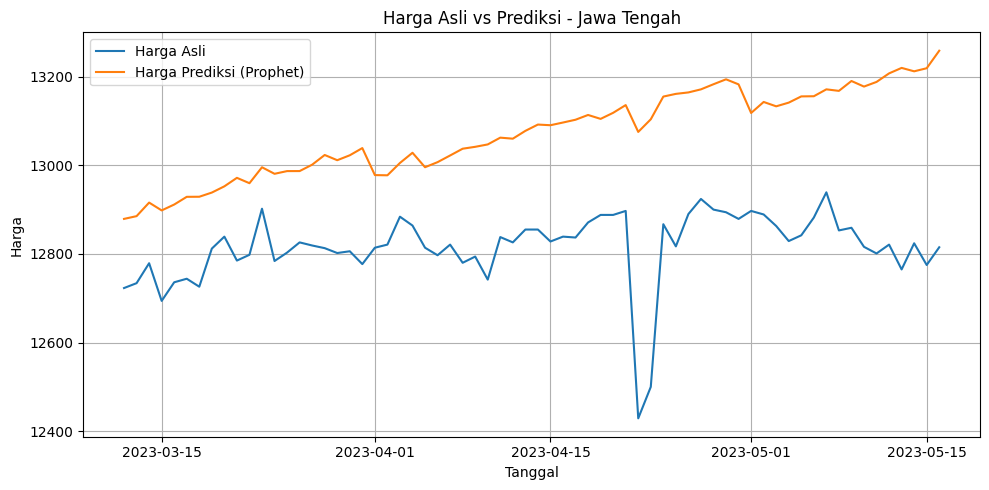

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(df_test['Tanggal'], y_true, label='Harga Asli')
plt.plot(df_test['Tanggal'], y_pred, label='Harga Prediksi (Prophet)')
plt.title(f'Harga Asli vs Prediksi - {prov}')
plt.xlabel('Tanggal')
plt.ylabel('Harga')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


05:21:57 - cmdstanpy - INFO - Chain [1] start processing
05:21:57 - cmdstanpy - INFO - Chain [1] done processing


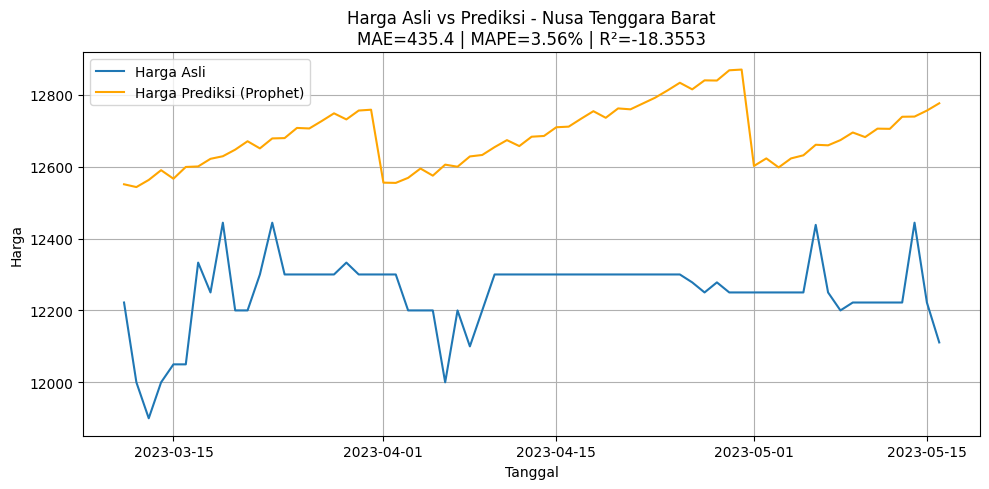

05:21:57 - cmdstanpy - INFO - Chain [1] start processing
05:21:57 - cmdstanpy - INFO - Chain [1] done processing


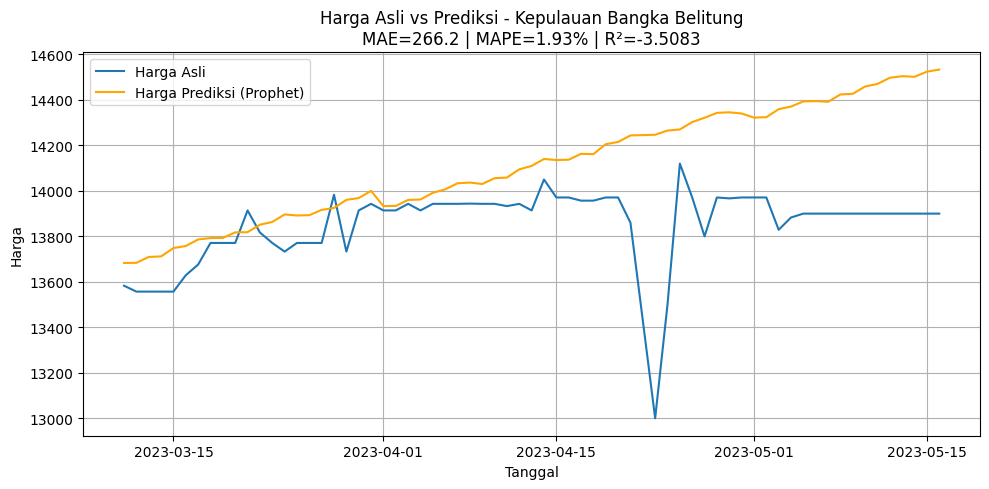

05:21:57 - cmdstanpy - INFO - Chain [1] start processing
05:21:57 - cmdstanpy - INFO - Chain [1] done processing


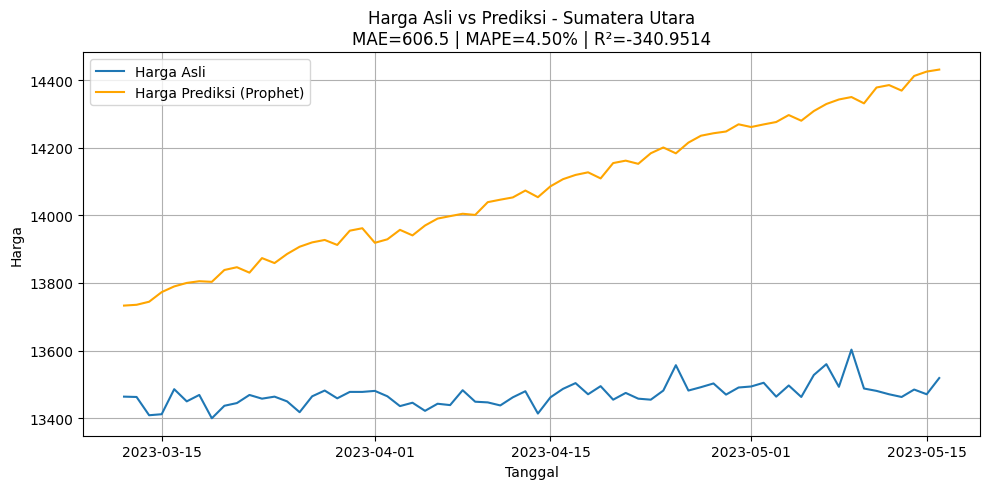

05:21:58 - cmdstanpy - INFO - Chain [1] start processing
05:21:58 - cmdstanpy - INFO - Chain [1] done processing


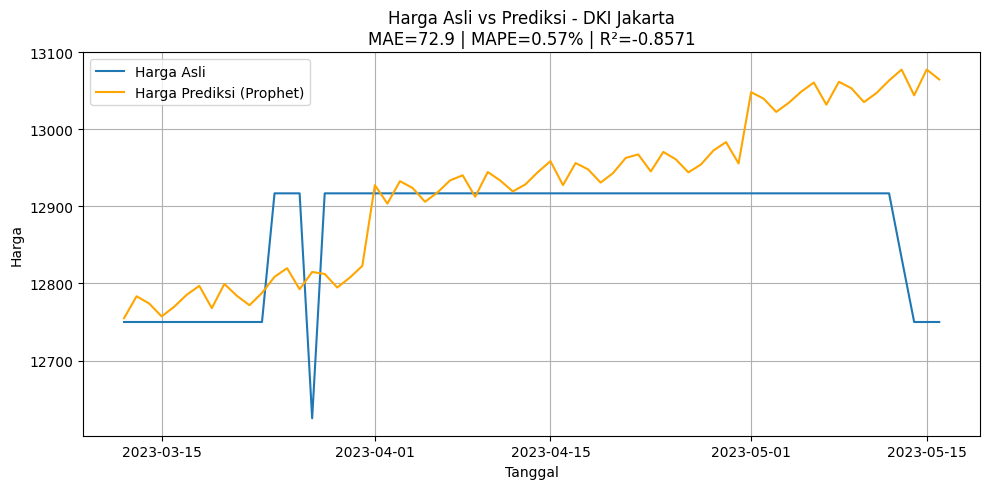

05:21:58 - cmdstanpy - INFO - Chain [1] start processing
05:21:58 - cmdstanpy - INFO - Chain [1] done processing


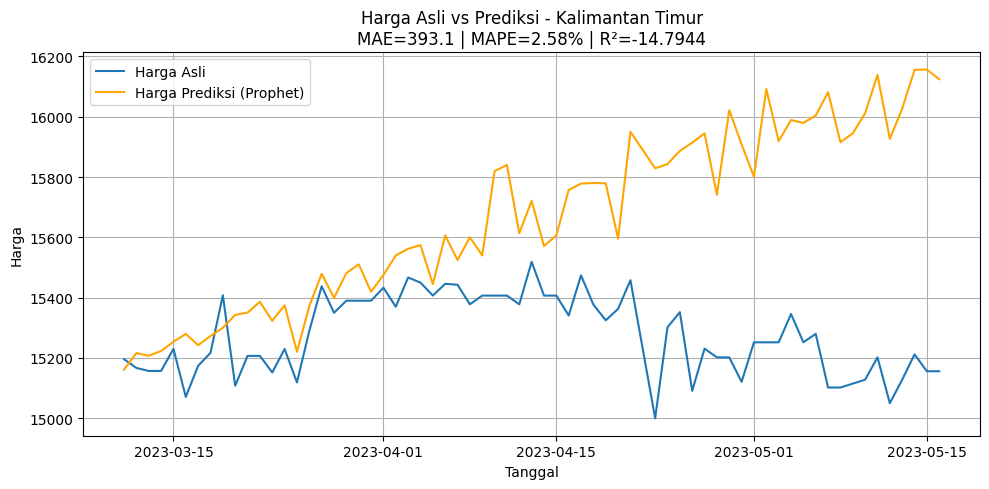

05:21:58 - cmdstanpy - INFO - Chain [1] start processing
05:21:58 - cmdstanpy - INFO - Chain [1] done processing


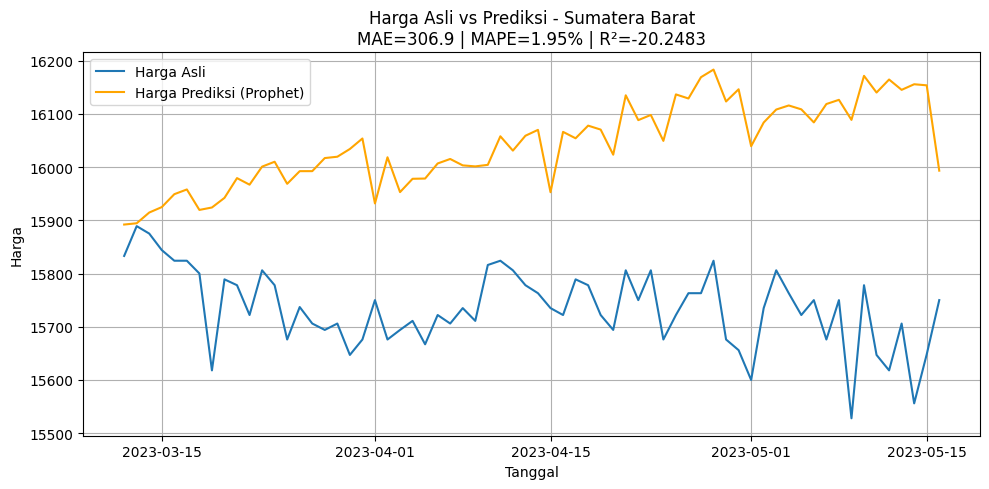

05:21:58 - cmdstanpy - INFO - Chain [1] start processing
05:21:58 - cmdstanpy - INFO - Chain [1] done processing


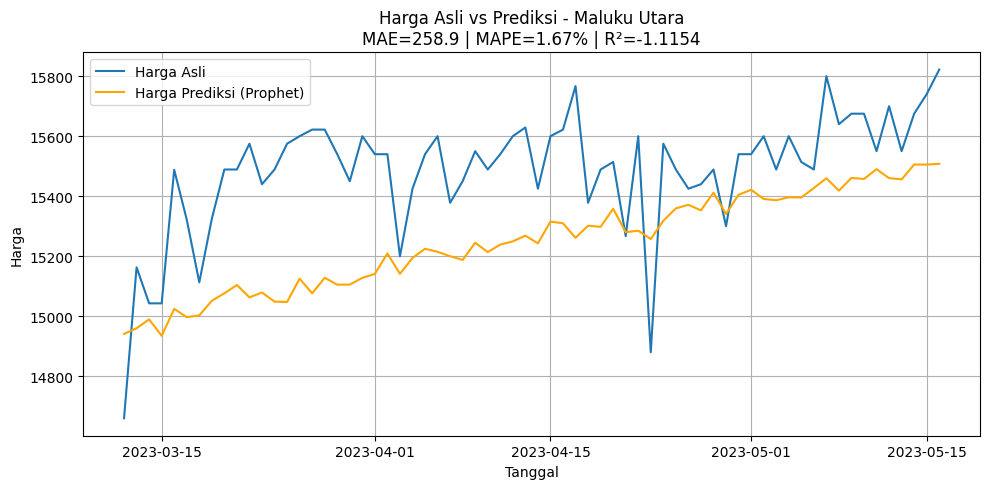

05:21:58 - cmdstanpy - INFO - Chain [1] start processing
05:21:58 - cmdstanpy - INFO - Chain [1] done processing


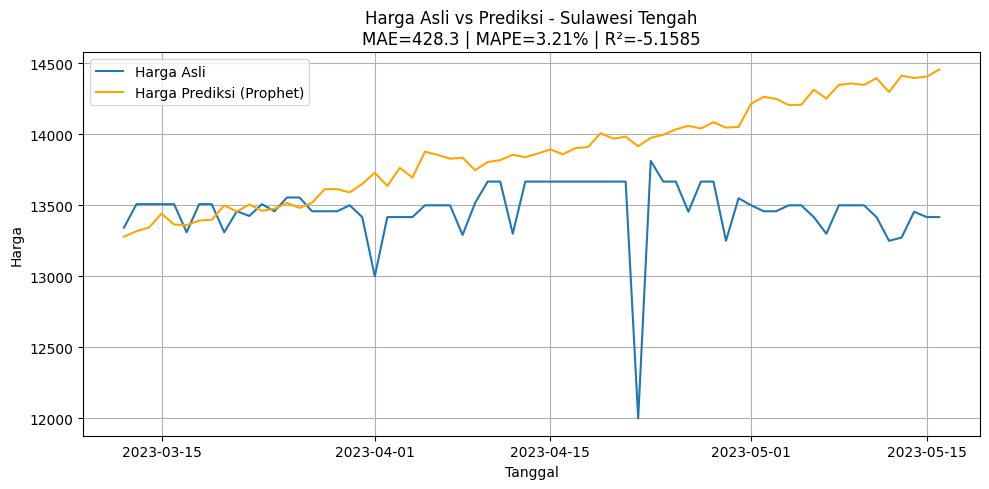

05:21:59 - cmdstanpy - INFO - Chain [1] start processing
05:21:59 - cmdstanpy - INFO - Chain [1] done processing


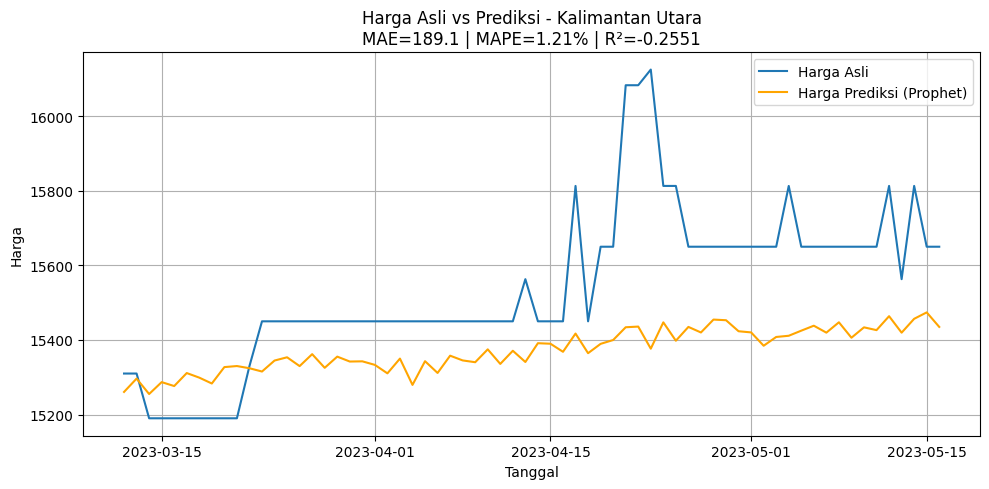

05:21:59 - cmdstanpy - INFO - Chain [1] start processing
05:21:59 - cmdstanpy - INFO - Chain [1] done processing


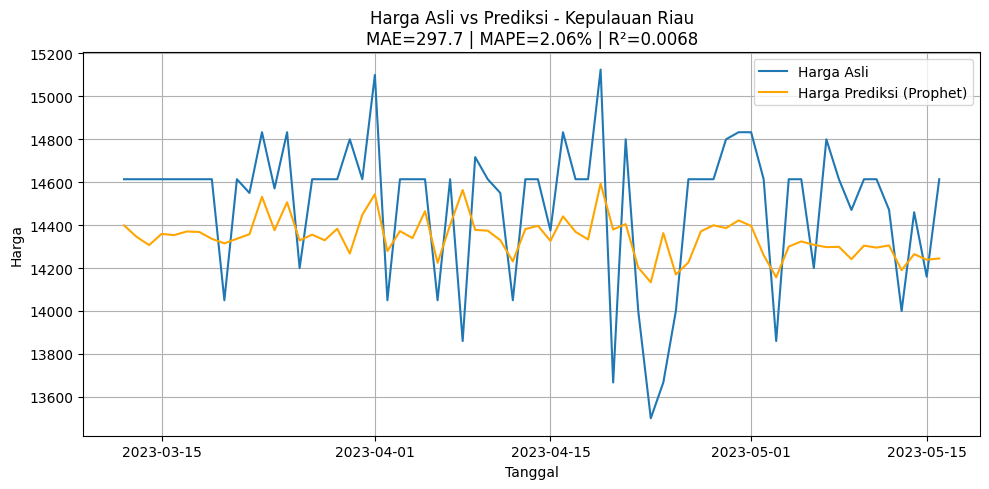

05:21:59 - cmdstanpy - INFO - Chain [1] start processing
05:21:59 - cmdstanpy - INFO - Chain [1] done processing


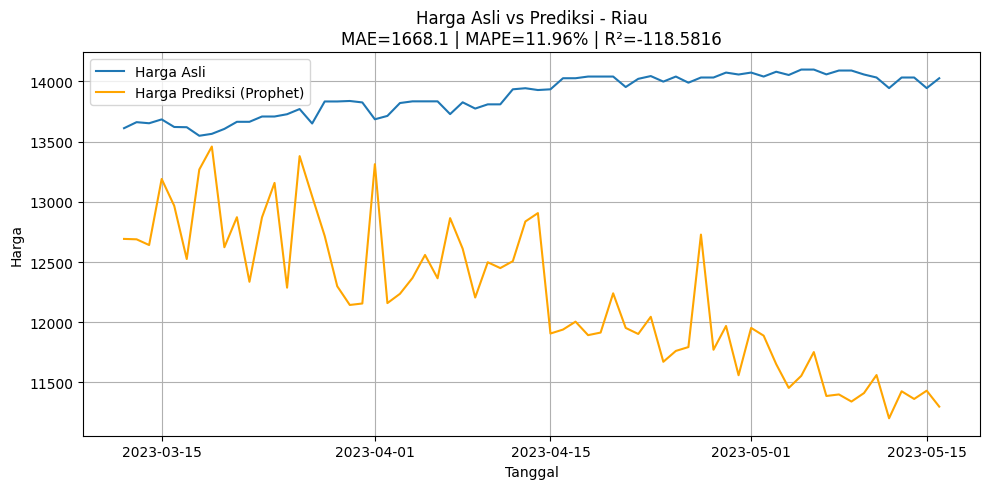

05:21:59 - cmdstanpy - INFO - Chain [1] start processing
05:21:59 - cmdstanpy - INFO - Chain [1] done processing


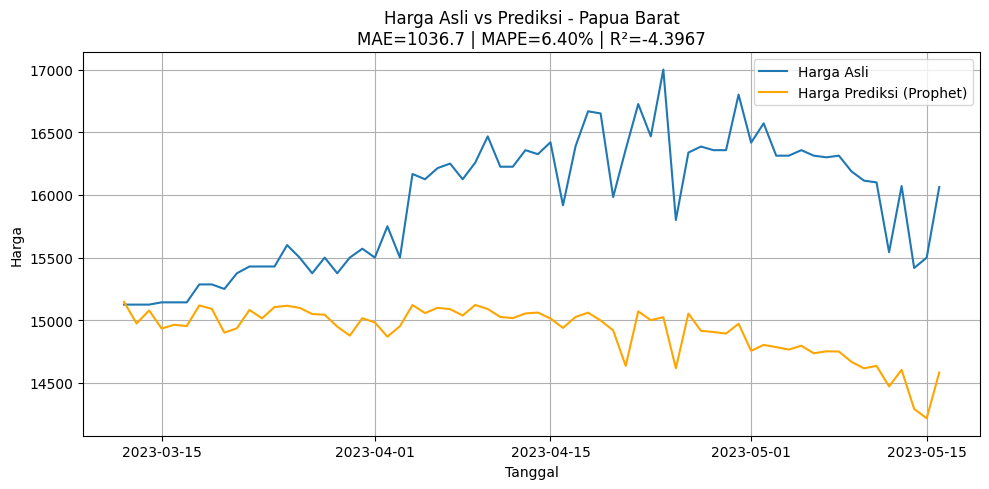

05:21:59 - cmdstanpy - INFO - Chain [1] start processing
05:21:59 - cmdstanpy - INFO - Chain [1] done processing


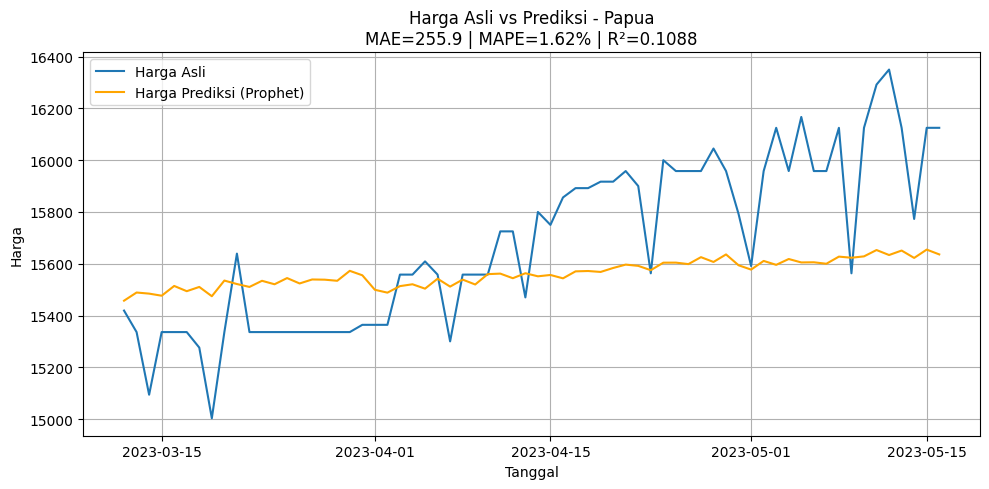

05:22:00 - cmdstanpy - INFO - Chain [1] start processing
05:22:00 - cmdstanpy - INFO - Chain [1] done processing


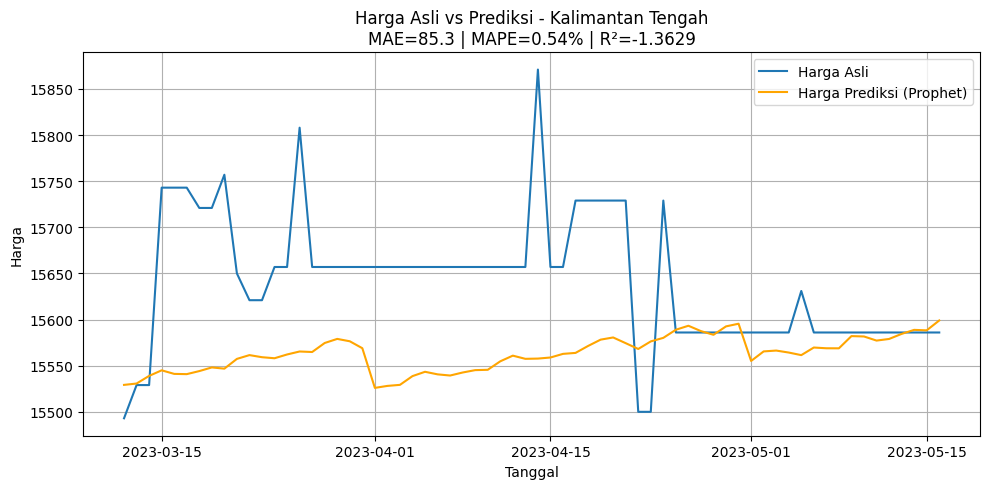

05:22:00 - cmdstanpy - INFO - Chain [1] start processing
05:22:00 - cmdstanpy - INFO - Chain [1] done processing


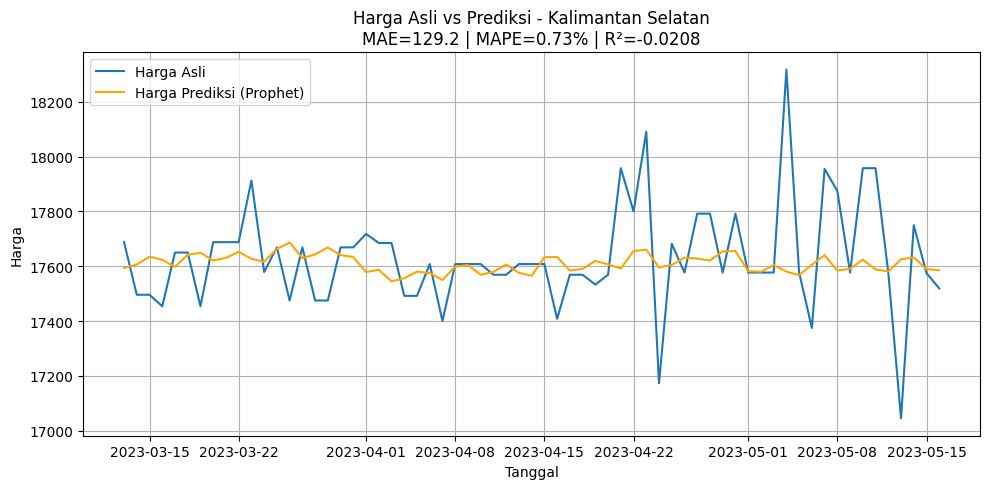

05:22:00 - cmdstanpy - INFO - Chain [1] start processing
05:22:00 - cmdstanpy - INFO - Chain [1] done processing


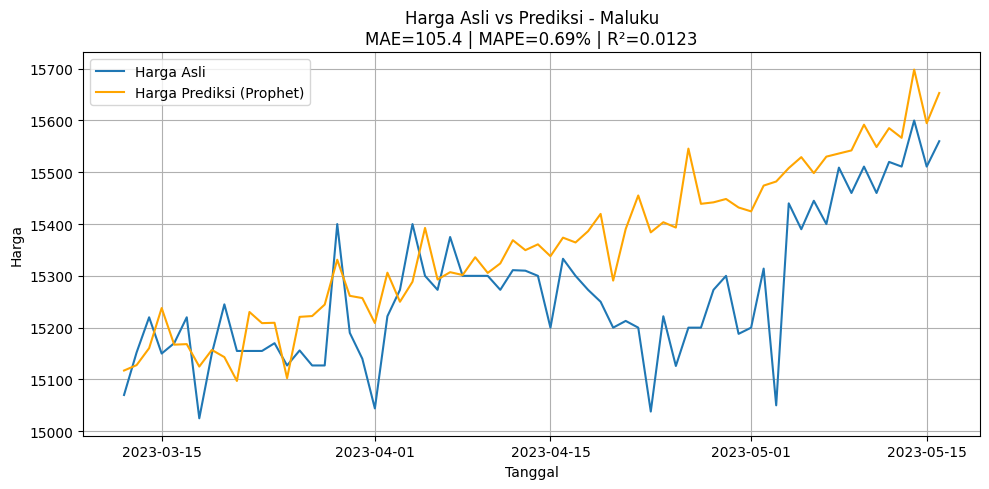

05:22:00 - cmdstanpy - INFO - Chain [1] start processing
05:22:00 - cmdstanpy - INFO - Chain [1] done processing


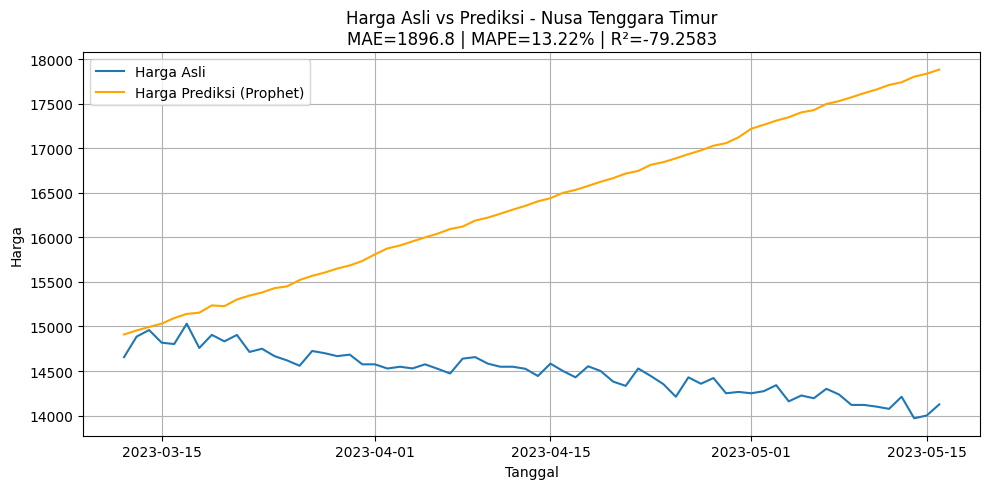

05:22:00 - cmdstanpy - INFO - Chain [1] start processing
05:22:01 - cmdstanpy - INFO - Chain [1] done processing


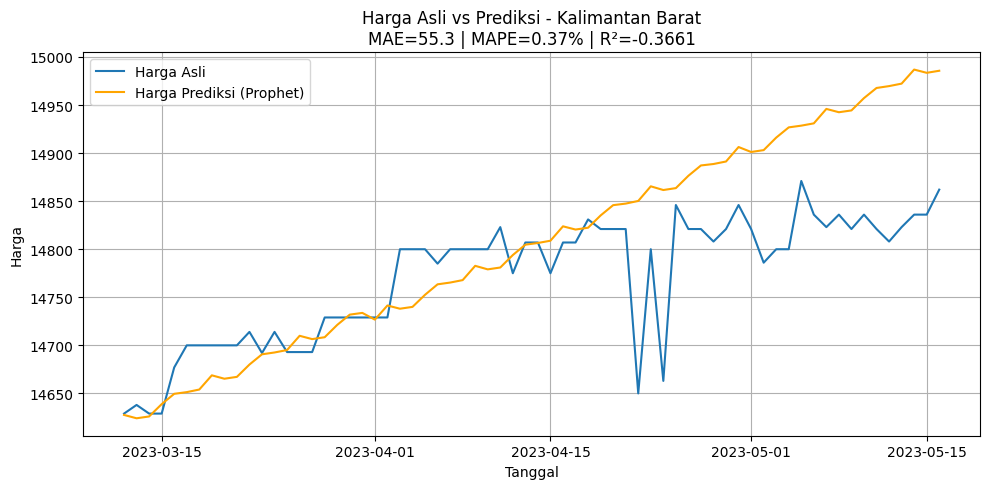

05:22:01 - cmdstanpy - INFO - Chain [1] start processing
05:22:01 - cmdstanpy - INFO - Chain [1] done processing


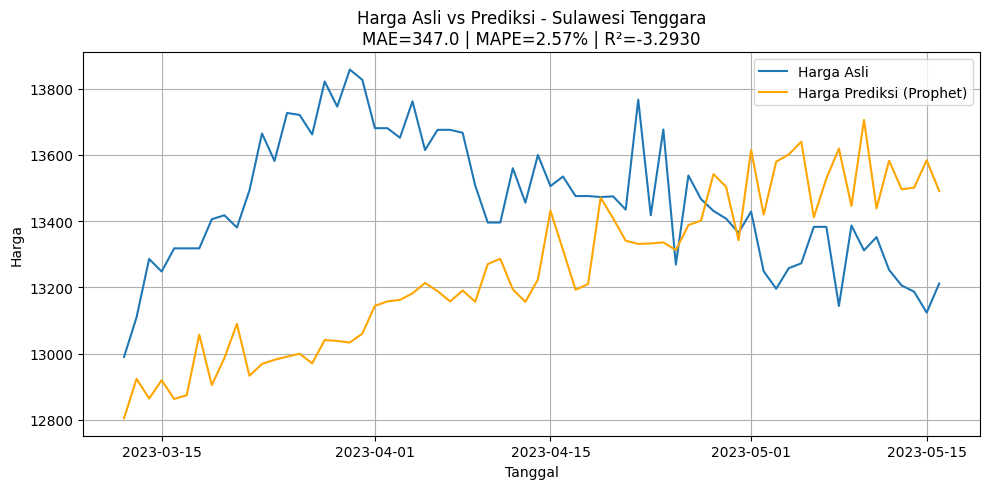

05:22:01 - cmdstanpy - INFO - Chain [1] start processing
05:22:01 - cmdstanpy - INFO - Chain [1] done processing


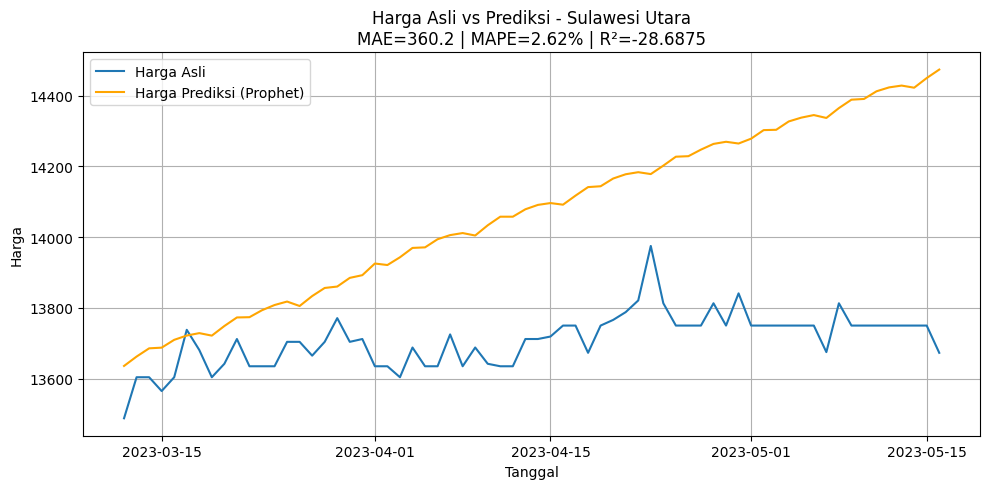

05:22:01 - cmdstanpy - INFO - Chain [1] start processing
05:22:01 - cmdstanpy - INFO - Chain [1] done processing


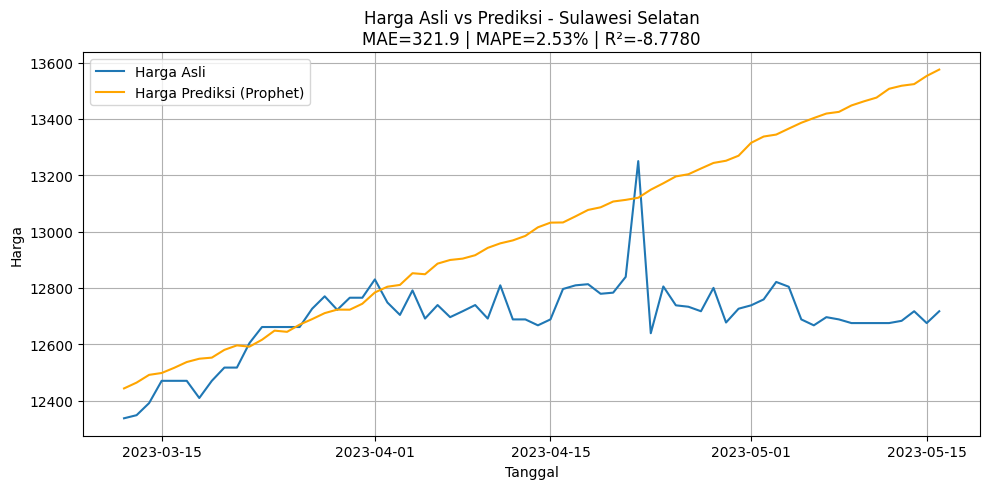

05:22:01 - cmdstanpy - INFO - Chain [1] start processing
05:22:01 - cmdstanpy - INFO - Chain [1] done processing


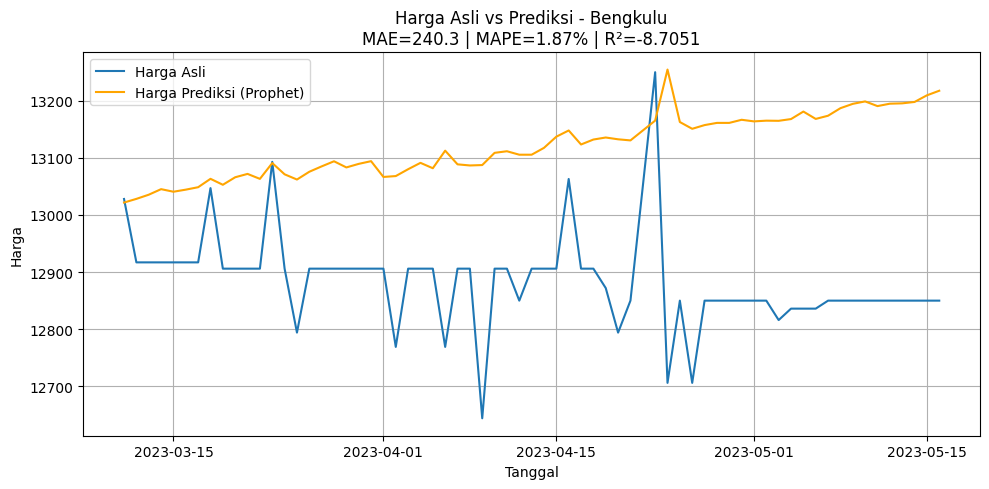

05:22:02 - cmdstanpy - INFO - Chain [1] start processing
05:22:02 - cmdstanpy - INFO - Chain [1] done processing


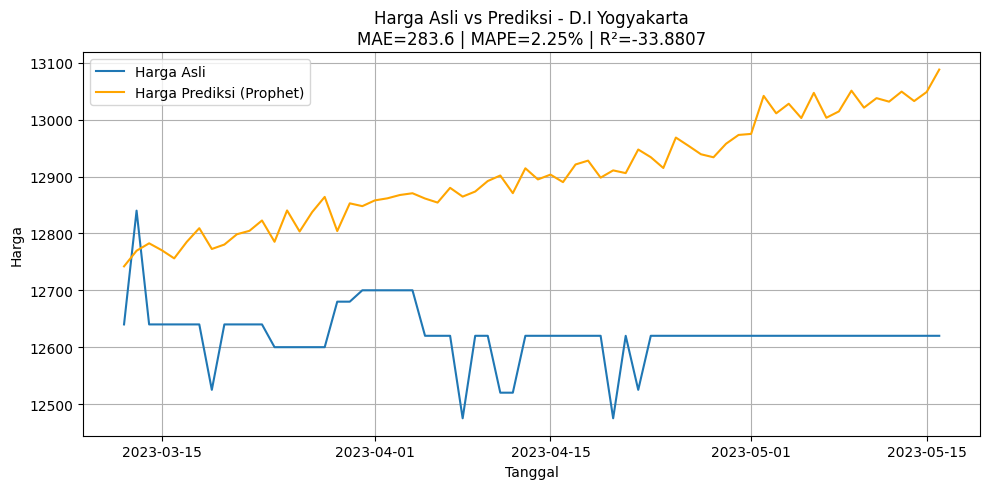

05:22:02 - cmdstanpy - INFO - Chain [1] start processing
05:22:02 - cmdstanpy - INFO - Chain [1] done processing


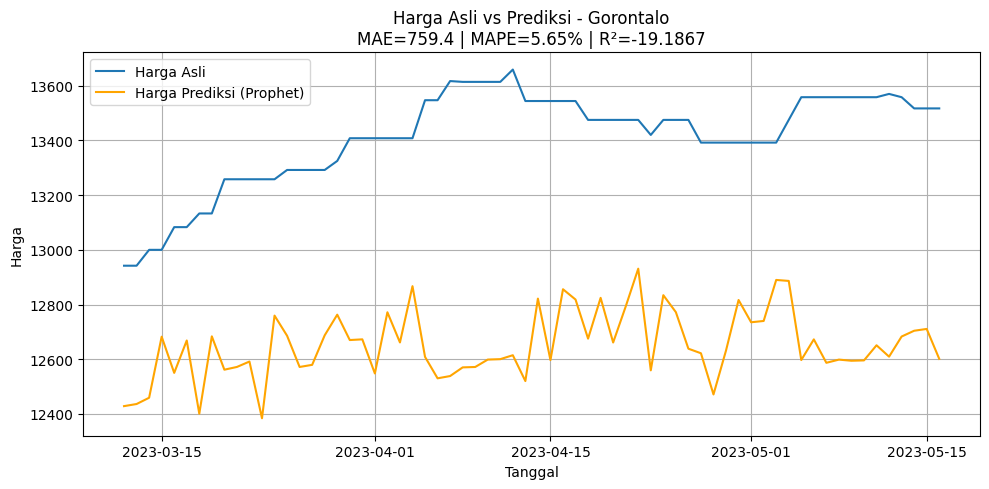

05:22:02 - cmdstanpy - INFO - Chain [1] start processing
05:22:02 - cmdstanpy - INFO - Chain [1] done processing


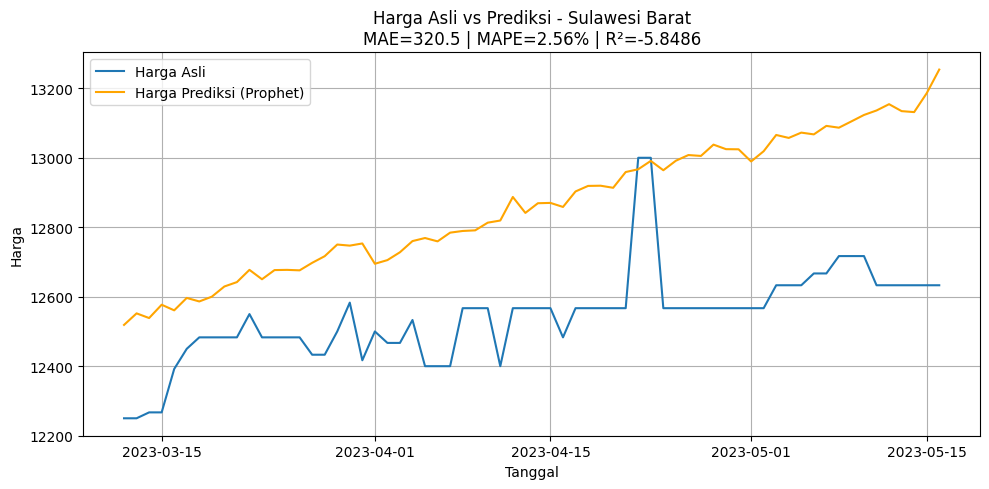

05:22:02 - cmdstanpy - INFO - Chain [1] start processing
05:22:02 - cmdstanpy - INFO - Chain [1] done processing


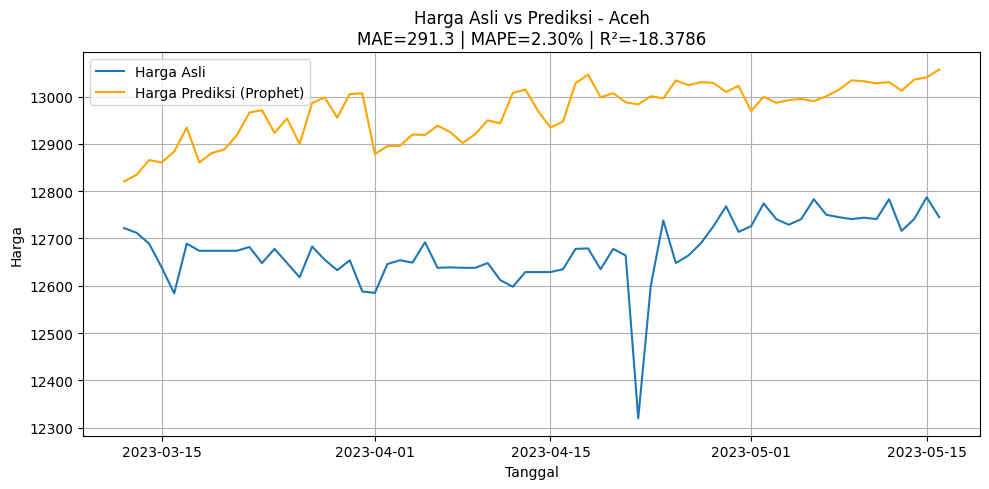

05:22:02 - cmdstanpy - INFO - Chain [1] start processing
05:22:02 - cmdstanpy - INFO - Chain [1] done processing


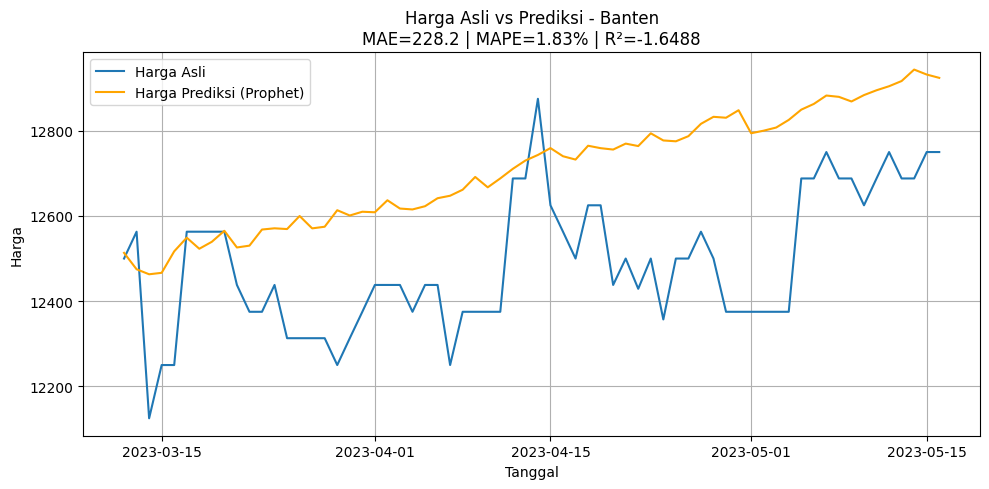

05:22:03 - cmdstanpy - INFO - Chain [1] start processing
05:22:03 - cmdstanpy - INFO - Chain [1] done processing


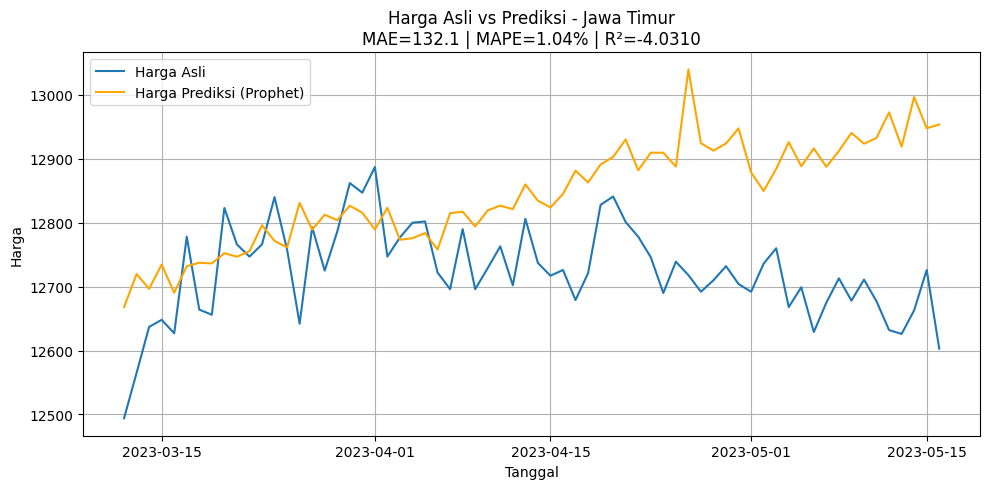

05:22:03 - cmdstanpy - INFO - Chain [1] start processing
05:22:03 - cmdstanpy - INFO - Chain [1] done processing


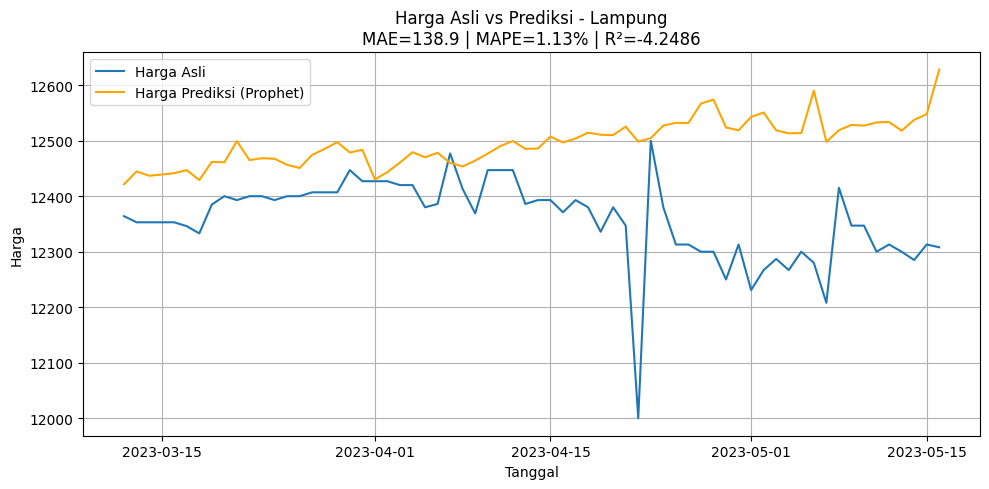

05:22:03 - cmdstanpy - INFO - Chain [1] start processing
05:22:03 - cmdstanpy - INFO - Chain [1] done processing


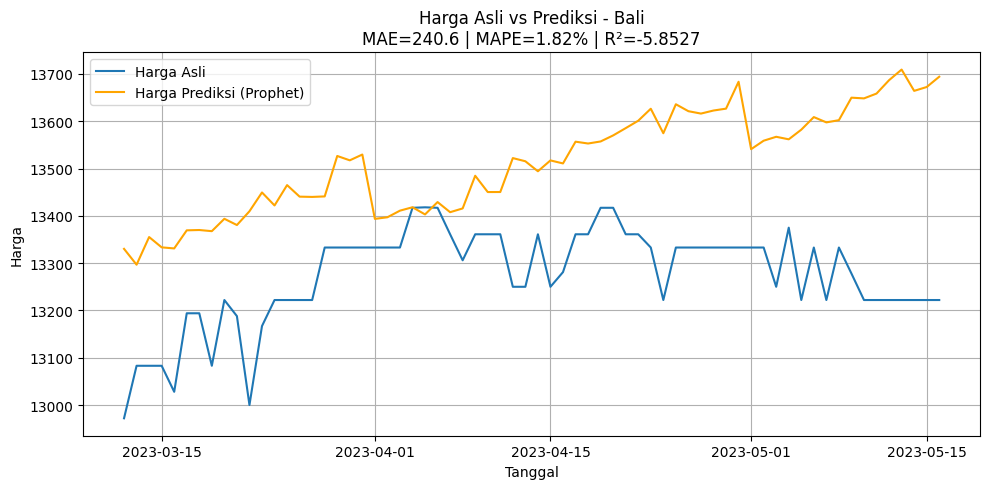

05:22:03 - cmdstanpy - INFO - Chain [1] start processing
05:22:03 - cmdstanpy - INFO - Chain [1] done processing


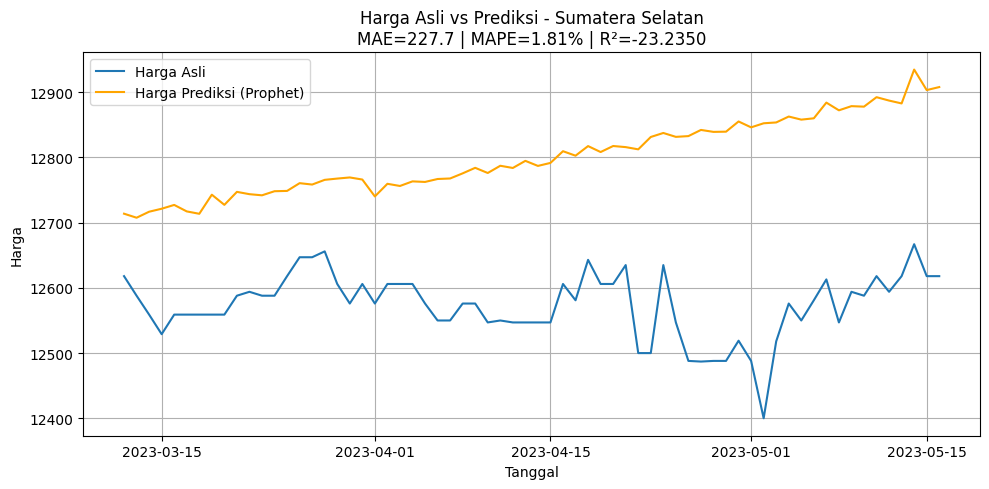

05:22:03 - cmdstanpy - INFO - Chain [1] start processing
05:22:04 - cmdstanpy - INFO - Chain [1] done processing


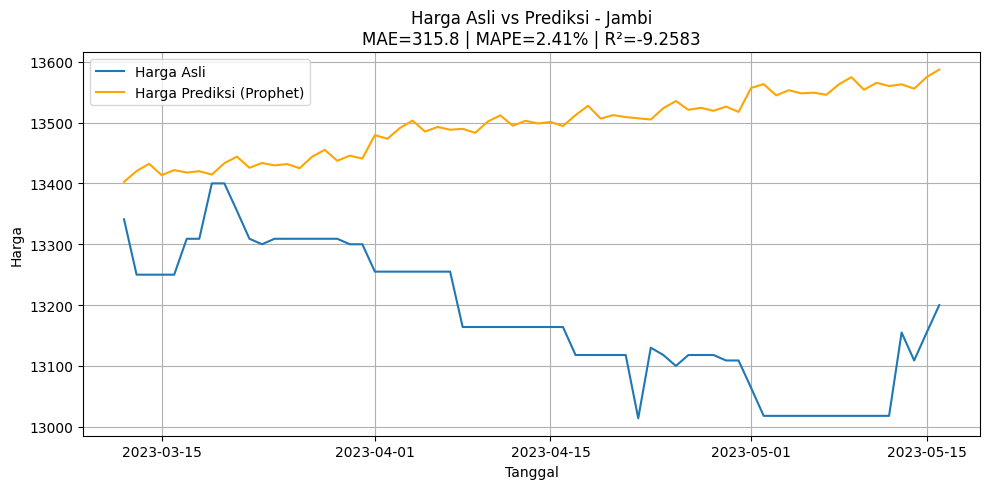

05:22:04 - cmdstanpy - INFO - Chain [1] start processing
05:22:04 - cmdstanpy - INFO - Chain [1] done processing


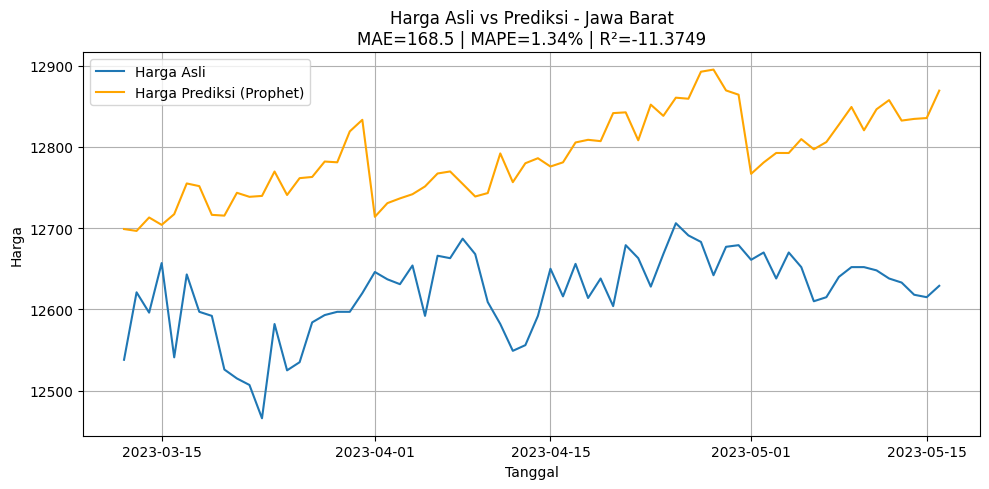

05:22:04 - cmdstanpy - INFO - Chain [1] start processing
05:22:04 - cmdstanpy - INFO - Chain [1] done processing


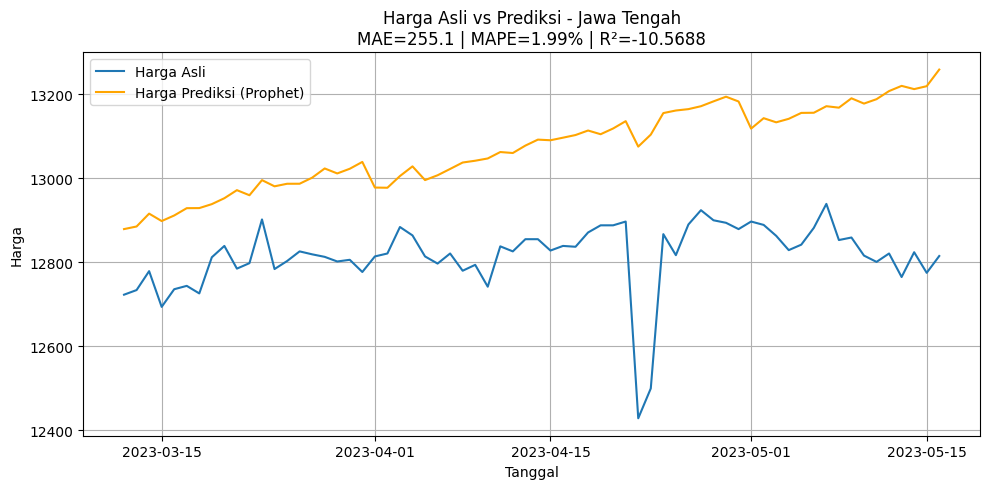

In [ ]:
provinsi_list = df_all['Provinsi'].unique()

for prov in provinsi_list:
    df_prov = df_all[df_all['Provinsi'] == prov].copy()
    
    # Hilangkan NaN pada fitur tambahan
    df_prov = df_prov.dropna(subset=['Harga_MA3', 'sin_month', 'cos_month'])
    
    # Split train-test (80:20)
    split_idx = int(len(df_prov) * 0.8)
    df_train = df_prov.iloc[:split_idx]
    df_test = df_prov.iloc[split_idx:]

    # Prophet perlu kolom 'ds' dan 'y'
    df_train = df_train.rename(columns={'Tanggal': 'ds', 'Harga': 'y'})

    # Buat dan latih model Prophet dengan eksternal regressor
    model = Prophet()
    model.add_regressor('Harga_MA3')
    model.add_regressor('sin_month')
    model.add_regressor('cos_month')

    model.fit(df_train[['ds', 'y', 'Harga_MA3', 'sin_month', 'cos_month']])

    # Siapkan data future dari test set
    df_future = df_test.rename(columns={'Tanggal': 'ds'})
    df_future = df_future[['ds', 'Harga_MA3', 'sin_month', 'cos_month']]
    
    forecast = model.predict(df_future)

    # Evaluasi
    y_true = df_test['Harga'].values
    y_pred = forecast['yhat'].values

    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    # Plot hasil
    plt.figure(figsize=(10, 5))
    plt.plot(df_test['Tanggal'], y_true, label='Harga Asli')
    plt.plot(df_test['Tanggal'], y_pred, label='Harga Prediksi (Prophet)', color='orange')
    plt.title(f'Harga Asli vs Prediksi - {prov}\nMAE={mae:.1f} | MAPE={mape:.2f}% | R²={r2:.4f}')
    plt.xlabel('Tanggal')
    plt.ylabel('Harga')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


## XGboost

In [ ]:
from xgboost import XGBRegressor
import xgboost as xgb


In [ ]:
feature_cols = ['day', 'month', 'year', 'provinsi_encoded', 'Harga_MA3', 'sin_month', 'cos_month']
target_col = 'Harga'

# Hilangkan baris dengan NaN (misalnya dari moving average)
df_clean = df_all.dropna(subset=feature_cols + [target_col])

In [ ]:
split_idx = int(len(df_clean) * 0.8)
df_train = df_clean.iloc[:split_idx]
df_test = df_clean.iloc[split_idx:]

X_train = df_train[feature_cols]
y_train = df_train[target_col]
X_test = df_test[feature_cols]
y_test = df_test[target_col]


In [ ]:
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)


In [ ]:
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("📊 Evaluasi Model XGBoost (semua data):")
print(f"MAE   : {mae:.2f}")
print(f"MAPE  : {mape:.2f}%")
print(f"MSE   : {mse:.2f}")
print(f"RMSE  : {rmse:.2f}")
print(f"R²    : {r2:.4f}")


📊 Evaluasi Model XGBoost (semua data):
MAE   : 598.11
MAPE  : 4.31%
MSE   : 615558.94
RMSE  : 784.58
R²    : 0.6659


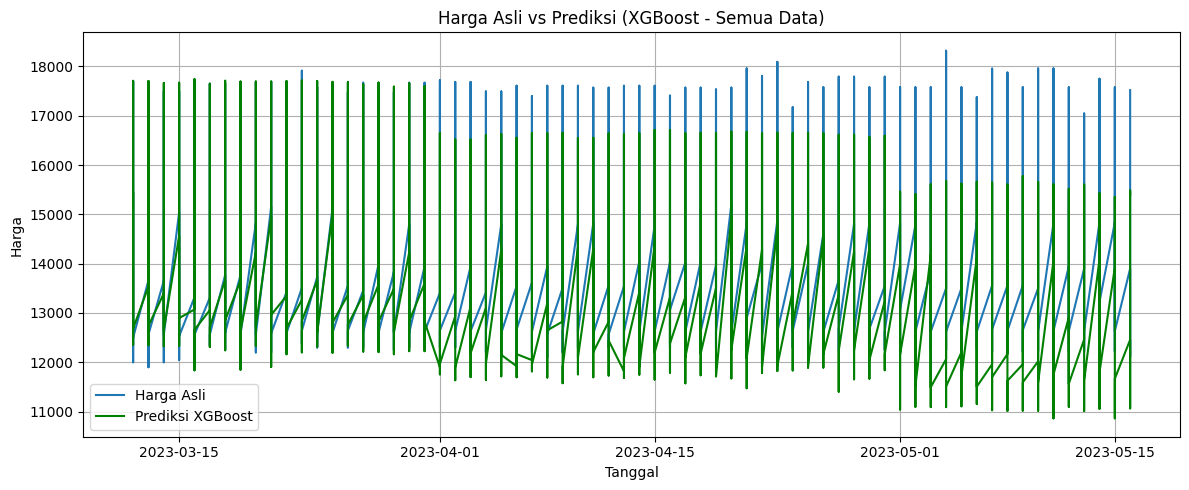

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(df_test['Tanggal'], y_test.values, label='Harga Asli')
plt.plot(df_test['Tanggal'], y_pred, label='Prediksi XGBoost', color='green')
plt.title('Harga Asli vs Prediksi (XGBoost - Semua Data)')
plt.xlabel('Tanggal')
plt.ylabel('Harga')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Urutkan data berdasarkan tanggal dan provinsi agar lag tidak kacau
df_all_sorted = df_all.sort_values(by=['Provinsi', 'Tanggal']).copy()

# Lag features
df_all_sorted['Harga_shift_1'] = df_all_sorted.groupby('Provinsi')['Harga'].shift(1)
df_all_sorted['Harga_shift_7'] = df_all_sorted.groupby('Provinsi')['Harga'].shift(7)

# Rolling statistics (window = 7 hari)
df_all_sorted['Harga_roll_std7'] = df_all_sorted.groupby('Provinsi')['Harga'].rolling(7).std().reset_index(0, drop=True)
df_all_sorted['Harga_roll_max7'] = df_all_sorted.groupby('Provinsi')['Harga'].rolling(7).max().reset_index(0, drop=True)
df_all_sorted['Harga_roll_min7'] = df_all_sorted.groupby('Provinsi')['Harga'].rolling(7).min().reset_index(0, drop=True)

# Hapus baris NaN hasil dari shift/rolling
df_all_fe = df_all_sorted.dropna(subset=[
    'Harga_shift_1', 'Harga_shift_7', 'Harga_roll_std7',
    'Harga_roll_max7', 'Harga_roll_min7'
])


In [ ]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

# Fitur yang digunakan
feature_cols = [
    'day', 'month', 'year', 'provinsi_encoded', 'Harga_MA3',
    'sin_month', 'cos_month',
    'Harga_shift_1', 'Harga_shift_7',
    'Harga_roll_std7', 'Harga_roll_max7', 'Harga_roll_min7'
]
target_col = 'Harga'

# Train-Test Split
split_idx = int(len(df_all_fe) * 0.8)
X_train = df_all_fe.iloc[:split_idx][feature_cols]
y_train = df_all_fe.iloc[:split_idx][target_col]

# Grid Search
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200],
    'subsample': [0.7, 1.0]
}

xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)

grid_search = GridSearchCV(estimator=xgb_model,
                           param_grid=param_grid,
                           cv=3,
                           scoring='neg_mean_absolute_error',
                           verbose=1,
                           n_jobs=-1)

grid_search.fit(X_train, y_train)


Fitting 3 folds for each of 36 candidates, totalling 108 fits


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, feature_weights=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 5, 7], 'n_estimators': [100, 200],
                         'subsample': [0.7, 1.0]},
             scoring='neg_mean_absolute_error', verbose=1)

In [ ]:
print("Best Parameters:", grid_search.best_params_)
print("Best MAE Score:", -grid_search.best_score_)


Best Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}
Best MAE Score: 98.50022050080595


In [ ]:
# Gunakan data uji (20% terakhir)
X_test = df_all_fe.iloc[split_idx:][feature_cols]
y_test = df_all_fe.iloc[split_idx:][target_col]

# Prediksi dengan model terbaik
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluasi
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Tampilkan hasil
print("📊 Evaluasi Model XGBoost (Tuning + FE):")
print(f"MAE   : {mae:.2f}")
print(f"MAPE  : {mape:.2f}%")
print(f"MSE   : {mse:.2f}")
print(f"RMSE  : {rmse:.2f}")
print(f"R²    : {r2:.4f}")


📊 Evaluasi Model XGBoost (Tuning + FE):
MAE   : 58.83
MAPE  : 0.46%
MSE   : 8049.38
RMSE  : 89.72
R²    : 0.9944


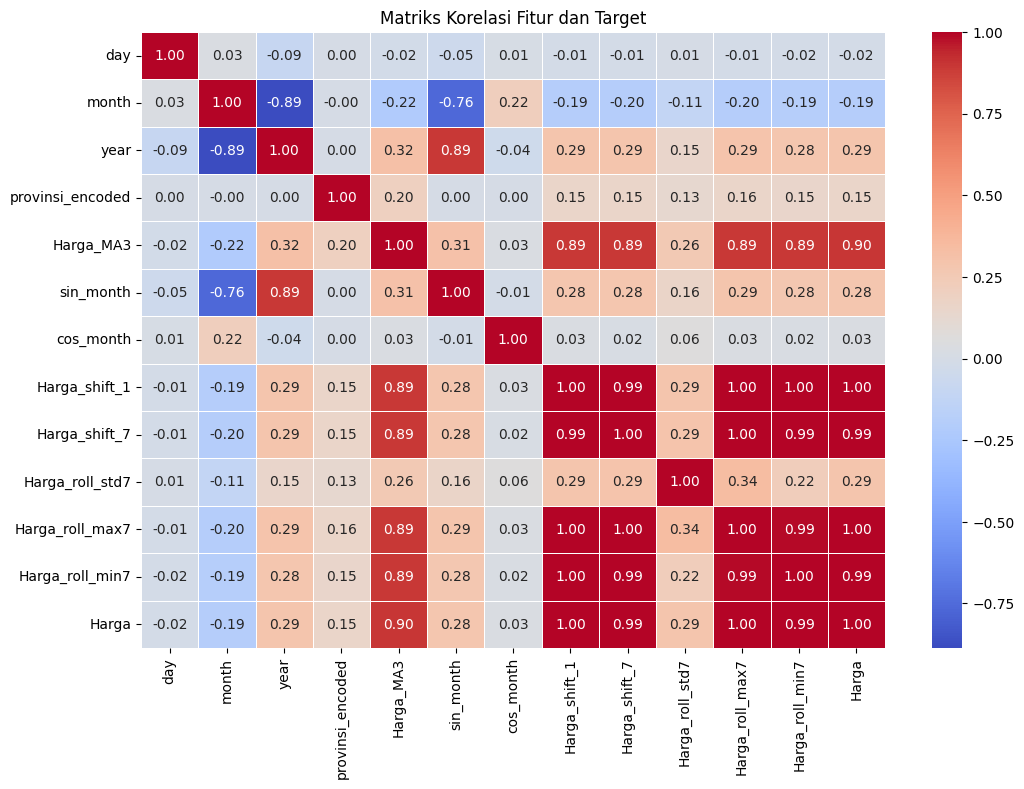

In [ ]:
# Ambil hanya kolom-kolom fitur dan target
corr_cols = feature_cols + [target_col]
corr_matrix = df_all_fe[corr_cols].corr()

# Plot matriks korelasi
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriks Korelasi Fitur dan Target')
plt.show()


In [ ]:
corr_with_target = corr_matrix[target_col].sort_values(ascending=False)
print(corr_with_target)


Harga               1.000000
Harga_shift_1       0.996454
Harga_roll_max7     0.996210
Harga_roll_min7     0.994958
Harga_shift_7       0.993802
Harga_MA3           0.898164
Harga_roll_std7     0.289882
year                0.289710
sin_month           0.281968
provinsi_encoded    0.153021
cos_month           0.029940
day                -0.015067
month              -0.194476
Name: Harga, dtype: float64


In [ ]:
# Ambil data terakhir untuk memulai prediksi
last_rows = df_all_fe[df_all_fe['Provinsi'] == df_all_fe['Provinsi'].iloc[-1]].copy()
future_preds = []

for i in range(30):
    last_row = last_rows.iloc[-1:].copy()
    
    # Update tanggal
    next_date = last_row['Tanggal'].values[0] + np.timedelta64(1, 'D')
    next_day = next_date.astype('datetime64[D]').astype(object).day
    next_month = next_date.astype('datetime64[M]').astype(object).month
    next_year = next_date.astype('datetime64[Y]').astype(object).year

    # Tambahkan sin/cos bulan
    sin_month = np.sin(2 * np.pi * next_month / 12)
    cos_month = np.cos(2 * np.pi * next_month / 12)

    # Buat input baru
    new_input = {
        'day': next_day,
        'month': next_month,
        'year': next_year,
        'provinsi_encoded': last_row['provinsi_encoded'].values[0],
        'Harga_MA3': last_rows['Harga'].rolling(3).mean().iloc[-1],
        'sin_month': sin_month,
        'cos_month': cos_month,
        'Harga_shift_1': last_row['Harga'].values[0],
        'Harga_shift_7': last_rows['Harga'].shift(6).iloc[-1],
        'Harga_roll_std7': last_rows['Harga'].rolling(7).std().iloc[-1],
        'Harga_roll_max7': last_rows['Harga'].rolling(7).max().iloc[-1],
        'Harga_roll_min7': last_rows['Harga'].rolling(7).min().iloc[-1],
    }

    X_new = pd.DataFrame([new_input])
    y_pred = best_model.predict(X_new)[0]

    # Simpan hasil prediksi
    future_preds.append({'Tanggal': next_date, 'Prediksi_Harga': y_pred})

    # Tambahkan ke data terakhir untuk digunakan prediksi hari berikutnya
    new_row = last_row.copy()
    new_row['Tanggal'] = next_date
    new_row['Harga'] = y_pred  # karena kita prediksi harga
    for col in ['day', 'month', 'year', 'sin_month', 'cos_month',
                'Harga_MA3', 'Harga_shift_1', 'Harga_shift_7',
                'Harga_roll_std7', 'Harga_roll_max7', 'Harga_roll_min7']:
        new_row[col] = X_new[col].values[0]

    last_rows = pd.concat([last_rows, new_row], ignore_index=True)


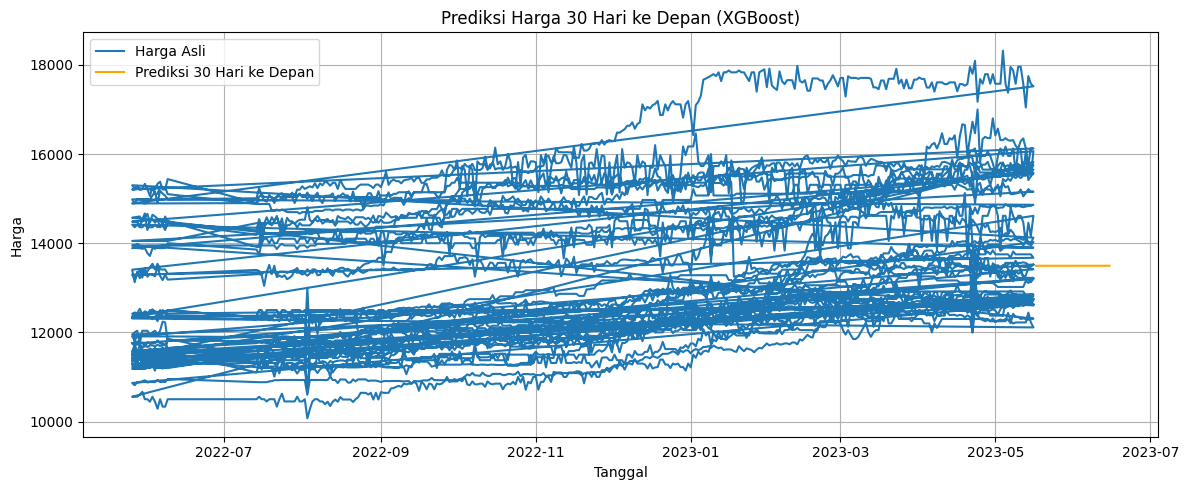

In [ ]:
df_preds = pd.DataFrame(future_preds)

plt.figure(figsize=(12,5))
plt.plot(df_all_fe['Tanggal'], df_all_fe['Harga'], label='Harga Asli')
plt.plot(df_preds['Tanggal'], df_preds['Prediksi_Harga'], label='Prediksi 30 Hari ke Depan', color='orange')
plt.title('Prediksi Harga 30 Hari ke Depan (XGBoost)')
plt.xlabel('Tanggal')
plt.ylabel('Harga')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


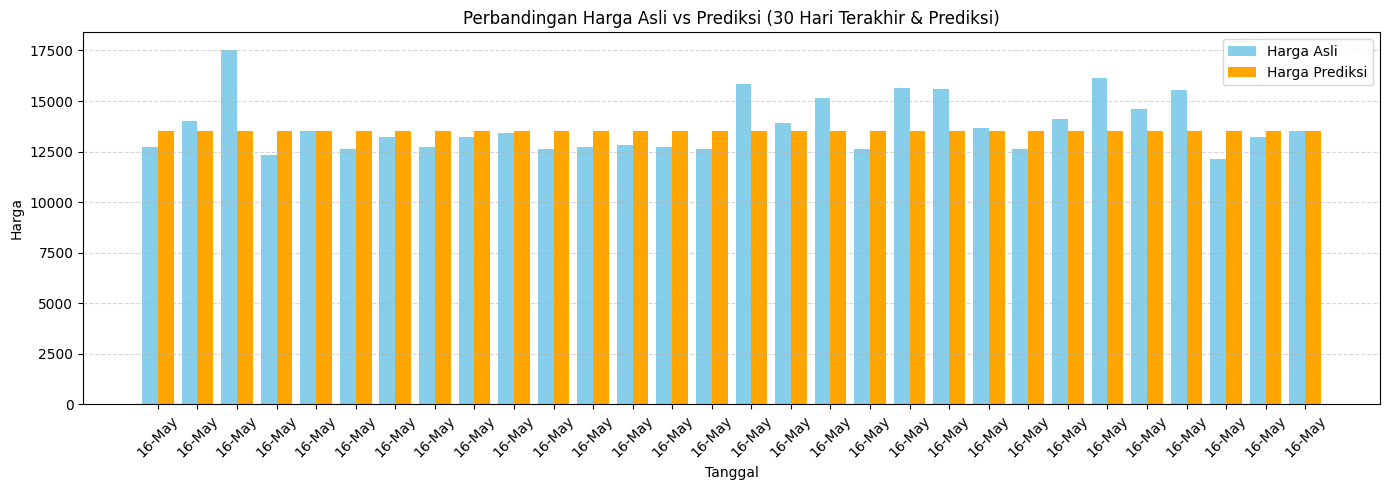

In [ ]:
# Ambil harga asli terakhir 30 hari (untuk perbandingan)
harga_asli_terakhir = df_all_fe[['Tanggal', 'Harga']].sort_values('Tanggal').iloc[-30:].reset_index(drop=True)

# Gabungkan dengan hasil prediksi
df_bar = harga_asli_terakhir.copy()
df_bar['Harga_Prediksi'] = df_preds['Prediksi_Harga'].values

# Plot barchart
x = np.arange(len(df_bar))
width = 0.4

plt.figure(figsize=(14,5))
plt.bar(x - width/2, df_bar['Harga'], width=width, label='Harga Asli', color='skyblue')
plt.bar(x + width/2, df_bar['Harga_Prediksi'], width=width, label='Harga Prediksi', color='orange')
plt.xticks(x, df_bar['Tanggal'].dt.strftime('%d-%b'), rotation=45)
plt.title('Perbandingan Harga Asli vs Prediksi (30 Hari Terakhir & Prediksi)')
plt.xlabel('Tanggal')
plt.ylabel('Harga')
plt.legend()
plt.tight_layout()
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.show()


In [ ]:
df_bar.head(10)

Tanggal    Harga  Harga_Prediksi
0 2023-05-16  12717.0    13494.206055
1 2023-05-16  14027.0    13493.943359
2 2023-05-16  17519.0    13493.943359
3 2023-05-16  12308.0    13493.943359
4 2023-05-16  13517.0    13493.943359
5 2023-05-16  12603.0    13493.943359
6 2023-05-16  13222.0    13493.943359
7 2023-05-16  12750.0    13493.943359
8 2023-05-16  13200.0    13493.943359
9 2023-05-16  13417.0    13493.943359

In [ ]:
df_bar['Error_Absolut'] = np.abs(df_bar['Harga'] - df_bar['Harga_Prediksi'])
df_bar['Error_Persen'] = df_bar['Error_Absolut'] / df_bar['Harga'] * 100
df_bar[['Tanggal', 'Harga', 'Harga_Prediksi', 'Error_Absolut', 'Error_Persen']].head(10)

Tanggal    Harga  Harga_Prediksi  Error_Absolut  Error_Persen
0 2023-05-16  12717.0    13494.206055     777.206055      6.111552
1 2023-05-16  14027.0    13493.943359     533.056641      3.800218
2 2023-05-16  17519.0    13493.943359    4025.056641     22.975379
3 2023-05-16  12308.0    13493.943359    1185.943359      9.635549
4 2023-05-16  13517.0    13493.943359      23.056641      0.170575
5 2023-05-16  12603.0    13493.943359     890.943359      7.069296
6 2023-05-16  13222.0    13493.943359     271.943359      2.056749
7 2023-05-16  12750.0    13493.943359     743.943359      5.834850
8 2023-05-16  13200.0    13493.943359     293.943359      2.226844
9 2023-05-16  13417.0    13493.943359      76.943359      0.573477

In [ ]:
# Misal df_bar adalah dataframe hasil prediksi 30 hari
y_true = df_bar['Harga']
y_pred = df_bar['Harga_Prediksi']

# Evaluasi
mae = mean_absolute_error(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)

# Tampilkan hasil
print("📊 Evaluasi Akhir XGBoost (30 Hari Terakhir)")
print(f"MAE   : {mae:.2f}")
print(f"MAPE  : {mape:.2f}%")
print(f"MSE   : {mse:.2f}")
print(f"RMSE  : {rmse:.2f}")
print(f"R²    : {r2:.4f}")



📊 Evaluasi Akhir XGBoost (30 Hari Terakhir)
MAE   : 1047.55
MAPE  : 7.25%
MSE   : 1894349.49
RMSE  : 1376.35
R²    : -0.0421
